In [ ]:
## parameters for experiment
N_BLOCK = 5
#LR = 0.00001
LR = 0.001

OUTPUT_DIR = '20251008-ClaheStackedRecreation'
RANDOM_SEED = 42

IN_CHANNEL = 1
OUT_CHANNEL = 11

AUGMENTED = True
AUGMENTATION  =  30


CROSS_VAL = True
N_SPLIT = 4


#optimization constants
DICE_IMPORTANCE = 1.0
CE_IMPORTANCE = 1.0

In [2]:
## import libraries
from numpy.core.numeric import NaN
from MCtool.RFilter import gray
from genericpath import exists
from matplotlib import image
import math
import sys
import time

import cv2
from matplotlib import pyplot as plt
from tensorflow.python.keras.backend import dtype
from DeepLearning import LearnAndTest
from Rpkg.Rfund.InputFeature import InputFeature
import datetime
import os
import gc
import tensorflow as tf
import random
import numpy as np
import pandas as pd

from Rpkg.Rfund import ReadFile, WriteFile
from Rpkg.Rmodel import Unet, Mnet

import Filtering

import torch
from torch import nn


import DeepLearning
from tensorflow.keras.optimizers import Adam

from Rpkg.Rfund.InputFeature import InputFeature
from Rpkg.Rfund import ReadFile, WriteFile
from Rpkg.Rmodel import Unet, Mnet

from MCtool import RFilter, resultEval
from DeepLearning import save_eval_result

import numpy as np
import cv2
import torch
from transformations import ComposeDouble, FunctionWrapperDouble, create_dense_target, normalize_01
from customdatasets import SegmentationDataSet1
from customdatasets import SegmentationDataSet4
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import pathlib
from skimage.transform import resize

#early stopping なし
from unet import UNet
from trainer import Trainer
from sklearn.model_selection import StratifiedKFold, train_test_split




2025-10-10 17:24:06.677648: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-10 17:24:07.400155: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
## random seed config
# Make sure there is no randomness in the output so that the output is reproduceable
import torch
import numpy as np
import random

# Set seed for Python random module
random.seed(RANDOM_SEED)

# Set seed for NumPy
np.random.seed(RANDOM_SEED)

# Set seed for PyTorch
torch.manual_seed(RANDOM_SEED)

# If you are using GPU
torch.cuda.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)

# Make the convolution operations deterministic
torch.backends.cudnn.deterministic = True

# Disable the CUDNN benchmark to ensure deterministic results
torch.backends.cudnn.benchmark = False


In [4]:
## cuda and pytorch stats
# 自分の環境設定がうまくいったかどうかを確認しましょう、特にGPUの動作
# Prints the version of PyTorch installed
print('PyTorch Version installed: ' + torch.__version__)

# Prints the version of CUDA associated with the installed PyTorch version
print('CUDA version associated with PyTorch version: ' + torch.version.cuda)

# Prints the version of cuDNN (CUDA Deep Neural Network library) being used by PyTorch
print('Version of cuDNN (CUDA Deep Neural Network library) being used by PyTorch' + str(torch.backends.cudnn.version()))

# Same as the line above
print('CUDA is available: ' + str(torch.cuda.is_available()))

# Returns the number of available CUDA-enabled GPUs
print('Number of GPUs compatible with CUDA:' + str(torch.cuda.device_count()))

# Returns the name of the GPU at index 0
print('Name of the GPU at index 0: '  + str(torch.cuda.get_device_name(0)))

# Returns the index of the current CUDA device being used
print('Current CUDA device index: '  + str(torch.cuda.current_device()))


PyTorch Version installed: 2.3.0+cu121
CUDA version associated with PyTorch version: 12.1
Version of cuDNN (CUDA Deep Neural Network library) being used by PyTorch8902
CUDA is available: True
Number of GPUs compatible with CUDA:1
Name of the GPU at index 0: NVIDIA GeForce RTX 2080 Ti
Current CUDA device index: 0


In [5]:
## file_names_with_prefix
# ファイル名の先頭部分（prefix）により自動的にファイル名を抽出するアルゴリズム。
# 実際それぞれのファイル名は違うと思うので、必須ではない

""" 

Extracts filenames in directory if they start with the prefix input 


Args/Parameters:

    directory_path (string): The path of the dir (ex: /root/home/Documents/etc)
    
    prefix (string): Prefix of the file name (ex: 'Bo' is a prefix of 'Bone')

Returns:

    sorted_file_names (list of str): File names sorted in ascending order in the dir without extension ex: ['bone1', 'bone2', ...]

Raises:

    SomeError: ...

"""

def file_names_with_prefix(directory_path, prefix):

    # Initialize an empty list to store the file names without extensions
    file_names_without_extension = []

    # Loop through all files in the specified directory
    for filename in os.listdir(directory_path):
        #Checking if the file in loop exists in the directory_path not sure how is this necessary
        #??
        if os.path.isfile(os.path.join(directory_path, filename)):
            # Check if the file name starts with the specified prefix
            if filename.startswith(prefix):
                # Get the file name without extension
                name_without_extension, _ = os.path.splitext(filename)

                # Append the file name (without extension) to the list
                file_names_without_extension.append(name_without_extension)

    # Sort the list of file names without extensions in ascending order
    sorted_file_names = sorted(
        file_names_without_extension,
        key=lambda x: (x.split('-')[0], int(x.split('-')[1]))
    )  # Modify this part based on your file naming convention

    # Now you have a sorted list of file names with the specified prefix and without extensions
    return sorted_file_names


In [6]:
## paths config
import pathlib
from pathlib import Path

# ここで、folder名とかPathとか色々設定

# Setting the directory name, path and other settings

# Define the root directory where your project is located
# Defining a Path object for the project's root dir
root_dir = Path(pathlib.Path.cwd())

# result folder name
#date_str = '20241202-Conv1x1-' + str(OUTPUT_DIR)
date_str = OUTPUT_DIR

# Define the directories for different types of data
# Concatenating the root dir to the different dataset dirs
data_dir = str(root_dir / "img_1006t/original")
feature_dir = str(root_dir / "img_1006t/feature") 
labeled_dir = str(root_dir / "img_1006t/labeled")

augmented_labeled_dir = str(root_dir / "img_1006t/labelAug")
augmented_data_dir = str(root_dir / "img_1006t/originalAug")
augmented_feature_dir = str(root_dir / "img_1006t/featureAug")


# data_dir = str(root_dir / "img_1006t/MC3x3(108_3out)/mcOriginal")
# feature_dir = str(root_dir / "img_1006t/MC3x3(108_3out)/mcFeature") 
# labeled_dir = str(root_dir / "img_1006t/labeled")

# augmented_labeled_dir = str(root_dir / "img_1006t/MC3x3(108_3out)/augMCLabel")
# augmented_data_dir = str(root_dir / "img_1006t/MC3x3(108_3out)/augMCOriginal")
# augmented_feature_dir = str(root_dir / "img_1006t/MC3x3(108_3out)/augMCFeature")

# annealing_img_dir = str(root_dir / "img_1006/annealing_img") # 焼きなまし法時に使う
# annealing later, original for now
annealing_img_dir = str(root_dir / "img_1006/original")
result_dir = str(root_dir / "result" / date_str)
test_result_dir= str(root_dir / "result_test" / date_str)

# Making directories based on the path string result_dir and test_result_dir
Path(result_dir).mkdir(parents=True, exist_ok=True)
Path(test_result_dir).mkdir(parents=True, exist_ok=True)

# Prints the paths of the dirs
print('Root directory: ' + str(root_dir))
print('Data directory (original dir): ' + str(data_dir))
print('Feature img directory: ' + str(feature_dir))
print('Labeled img directory: ' + str(labeled_dir))
print('Annealing directory: ' + str(annealing_img_dir))
print('Result directory: ' + str(result_dir))
print('Test result directory: ' + str(test_result_dir))

# Defining variables filename list of path str starts with the prefix format
# In this case: N1 and N3 is training data and N2 is validation data and N4 is a test data
input_train = []
input_name_val = []
annealing_input_name = []
input_train = []
test_input_name = []


# for raw_input_img in INPUT:
#     input_train.extend(file_names_with_prefix(data_dir, raw_input_img))
# for raw_val_img in VALIDATION:
#     input_name_val.extend(file_names_with_prefix(data_dir, raw_val_img))
# for raw_anneal in ANNEALING:
#     annealing_input_name.extend(file_names_with_prefix(data_dir, raw_anneal))
# for raw_test in TEST:
#     test_input_name.extend(file_names_with_prefix(data_dir, raw_test))


####old version of assigning
# input_train = file_names_with_prefix(data_dir, INPUT)
# input_name_val = file_names_with_prefix(data_dir, VALIDATION)
# annealing_input_name = file_names_with_prefix(data_dir, ANNEALING)
# test_input_name = file_names_with_prefix(data_dir, TEST) 


# extra_dataset = file_names_with_prefix(data_dir,'N5-')
# input_train.extend(extra_dataset)

# Prints the each data image name
# print(input_train)
# print(input_name_val)
# print(annealing_input_name)
# print(test_input_name)
# print(extra_dataset)


# Defining a var to store each list length
len_train = len(input_train)
len_val = len(input_name_val)
len_test = len(test_input_name)
len_annealing = len(annealing_input_name)


# print(len(input_train))

# print(len(input_name_val))
# print(len(test_input_name))
# print(len(annealing_input_name))


Root directory: /home/eric/Documents/cervicalResearchIIP
Data directory (original dir): /home/eric/Documents/cervicalResearchIIP/img_1006t/original
Feature img directory: /home/eric/Documents/cervicalResearchIIP/img_1006t/feature
Labeled img directory: /home/eric/Documents/cervicalResearchIIP/img_1006t/labeled
Annealing directory: /home/eric/Documents/cervicalResearchIIP/img_1006/original
Result directory: /home/eric/Documents/cervicalResearchIIP/result/20251008-ClaheStackedRecreation
Test result directory: /home/eric/Documents/cervicalResearchIIP/result_test/20251008-ClaheStackedRecreation


In [7]:
## feature list definition
# 特徴画像の特徴一覧をリストとして取得#
#inputfeature_list = list(map(str, InputFeature))
inputfeature_list = ['CLA_']

# inputfeature_list = ["GRY_", "NML1", "NML2", "NML3", "NML1", "MEA1",
#                      "MEA2", "MED1", "MED2", "NML1", "NGP_", "KNN1",
#                      "KNN2", "BLT1", "BLT2", "UNS1", "UNS2", "UNS3",
#                      "UNS4", "UNS5", "ERO1", "ERO2", "ERO3", "ERO4",
#                      "ERO5", "ERO6", "OPN1", "OPN2", "OPN3", "OPN4",
#                      "OPN5", "CLO1", "CLO2", "CLO3", "CLO4", "CLO5",
#                      "MIN1", "MIN2", "MIN3", "MIN4", "MAX1", "MAX2",
#                      "MAX3", "MAX4", "MRL1", "MRL2", "MRL3", "MRL4",
#                      "RIC_",
#                      ]



# unet only
#inputfeature_list = inputfeature_list[:1]

#inputfeature_list.clear()

#inputfeature_list.append("RIC_")
#print(inputfeature_list)

#inputfeature_list.remove(OUTPUT_DIR[-4:])
# inputfeature_list.remove("TOP1")
# inputfeature_list.remove("TOP2")
# inputfeature_list.remove("TOP3")
# inputfeature_list.remove("TOP4")

# inputfeature_list.remove("SBLX")
# inputfeature_list.remove("SBLY")
# inputfeature_list.remove("SBLM")
# inputfeature_list.remove("SBLD")
# inputfeature_list.remove("SBL1")
# inputfeature_list.remove("SBL2")
# inputfeature_list.remove("SBL3")
# inputfeature_list.remove("SBL4")

# inputfeature_list.remove("LPL1")
# inputfeature_list.remove("LPL2")

# inputfeature_list.remove("LBP1")
# inputfeature_list.remove("LBP2")
# inputfeature_list.remove("LBP3")

# inputfeature_list.remove("SOL_")
# inputfeature_list.remove("OOO_")

# inputfeature_list.remove("CAN1")
# inputfeature_list.remove("CAN2")
# inputfeature_list.remove("CAN3")


# inputfeature_list.remove("FOU1")
# inputfeature_list.remove("FOU2")
# inputfeature_list.remove("FOU3")
# inputfeature_list.remove("FOU4")

# inputfeature_list.remove("SCH1")
# inputfeature_list.remove("SCH2")
# inputfeature_list.remove("SCH3")
# inputfeature_list.remove("SCH4")

# inputfeature_list.remove("ROB1")
# inputfeature_list.remove("ROB2")
# inputfeature_list.remove("ROB3")
# inputfeature_list.remove("ROB4")

# inputfeature_list.remove("MRG1")
# inputfeature_list.remove("MRG2")
# inputfeature_list.remove("MRG3")
# inputfeature_list.remove("MRG4")

# inputfeature_list.remove("BTM1")
# inputfeature_list.remove("BTM2")
# inputfeature_list.remove("BTM3")
# inputfeature_list.remove("BTM4")

# inputfeature_list.remove("DST_")
# inputfeature_list.remove("HOM_")

# for i in range(108):
#     stckd_feature_name = "NGP_" + inputfeature_list[i]
#     inputfeature_list.append(stckd_feature_name)

# for input_feature in inputfeature_list[:]:
#     if not input_feature.startswith("NGP"):
#         inputfeature_list.remove(input_feature)
        


print(inputfeature_list)
feature_num = len(inputfeature_list)


print(feature_num)

['CLA_']
1


In [ ]:
## createweightimage read by images
# takes too much memory cuz it loads all images into np array at once


## 重み計算なし
def CreateWeightImage(input_number, augmentation=False):
    print("Creating image arrays...")
    label_dataset = []
    arrDataset = []
    for i in input_number:
        if augmentation:
            label_path = os.path.join(augmented_labeled_dir, str(AUGMENTATION) + "aug/" , f"{i}.png")
        else:
            label_path = os.path.join(labeled_dir, f"{i}.png")
        input_originallabel = cv2.imread(label_path, cv2.IMREAD_GRAYSCALE)
        
        labeled_image = []
        
        for i in range(OUT_CHANNEL - 1):
            labeled_image_i = np.where(input_originallabel == i + 1, 1, 0).astype(np.float32)
            labeled_image.append(labeled_image_i)
                   
        label_dataset.append(labeled_image)

    print("Number of label images:", len(label_dataset))


    
    for i in input_number:
        # changed this part from 100 to 256

        dataset_img =  np.zeros((256, 256, feature_num), dtype=np.float32)
            
            
        for m in range(feature_num):
            if augmentation:
                feature_img_path = os.path.join(augmented_feature_dir, str(AUGMENTATION) + "aug/" , str(i), f"{inputfeature_list[m]}.png")
            else:
                feature_img_path = os.path.join(feature_dir, str(i), f"{inputfeature_list[m]}.png")
            input_featureimg = cv2.imread(feature_img_path, cv2.IMREAD_GRAYSCALE)
            dataset_img[:, :, m] = input_featureimg

        arrDataset.append(dataset_img)

    arrDataset = np.array(arrDataset)
    print("Completed creating image arrays:")
    print("Dataset shape ", arrDataset.shape)
    print("Label image shape ", np.shape(label_dataset))
    print()

    return arrDataset, label_dataset


In [9]:
## createweightimagenew read paths only
def CreateWeightImageNew(input_numbers, augmentation=False):
    print("Creating image paths...")
    label_paths = []
    feature_paths = []

    for i in input_numbers:
        if augmentation:
            label_path = os.path.join(augmented_labeled_dir, str(AUGMENTATION) + "aug/", f"{i}.png")
        else:
            label_path = os.path.join(labeled_dir, f"{i}.png")
        label_paths.append(label_path)

        feature_img_paths = []
        for feature_name in inputfeature_list:
            if augmentation:
                feature_img_path = os.path.join(augmented_feature_dir, str(AUGMENTATION) + "aug/", str(i), f"{feature_name}.png")
            else:
                feature_img_path = os.path.join(feature_dir, str(i), f"{feature_name}.png")
            feature_img_paths.append(feature_img_path)

        feature_paths.append(feature_img_paths)

    print(f"Processed {len(label_paths)} label paths and {len(feature_paths)} feature paths.")
    return feature_paths, label_paths


In [10]:
## create weight test example

# input_dataset,label_dataset = CreateWeightImage(input_train)
# input_dataset_val,label_dataset_val = CreateWeightImage(input_name_val)



In [11]:
## createweightimageforshow
# # # 重みを基づいて、MC画像を生成する
# # # function for showing MC image
# # # gets 1d array as weight, input_number is image name, and index is directory name for the mc image to save
# def CreateWeightImageforShow(weight, input_number, index):
#     sum_weight = sum(weight)  # Calculate total weight

#     label_dataset = []
#     input_dataset = []
#     dataset_original = []

#     # Read label images
#     for i in input_number:
#         input_originallabel = cv2.imread(labeled_dir + "/" + str(i) + ".png", flags=0)
#         label_dataset.append(input_originallabel)

#     print('Weight image for show, label length = ', len(label_dataset))

#     # Create output directory
#     os.makedirs(test_result_dir + "/weightImage/" + str(index), exist_ok=True)

#     # Generate weighted images
#     for i in input_number:
#         # Create a blank image to store the weighted image, using float type for accumulation
#         dataset_img = np.zeros((256, 256, 3), dtype=np.float32)
#         input_originalimg = cv2.imread(data_dir + "/" + str(i) + ".png")

#         dataset_original.append(input_originalimg)
#         for m in range(feature_num):
#             input_featureimg = cv2.imread(feature_dir + "/" + str(i) + "/" + inputfeature_list[m] + ".png", cv2.IMREAD_GRAYSCALE)
#             # Normalize the feature image
#             normalized_feature_img = cv2.normalize(input_featureimg.astype(np.float32), None, 0, 1, cv2.NORM_MINMAX)
#             # Accumulate the weighted feature image
#             dataset_img += normalized_feature_img[:, :, None] * (weight[m] / sum_weight)  # Convert 2D array to 3D array

#         # Normalize the accumulated image to the range 0-255
#         dataset_img = cv2.normalize(dataset_img, None, 0, 255, cv2.NORM_MINMAX)
#         output_img = dataset_img.astype(np.uint8)  # Convert to uint8

#         input_dataset.append(output_img)
#         # Write to file
#         cv2.imwrite(f"{test_result_dir}/weightImage/{index}/{i}.png", output_img)

#     return input_dataset, label_dataset


In [12]:
## value extraction for visual mc
# # ## Netron app to extract the weight tensor
# # ## if the conv is 1x1 the tensor has 45 values
# # ## if the conv is 3x3 there are 9 x 45 values so the function averages 9 value into 1 and so on
# def compute_mean_values(input_list):
#     """
#     Compute mean of 3x3 blocks in each channel of the input list.
    
#     Args:
#         input_list (list): A 4D list of shape (1, C, H, W).
        
#     Returns:
#         list: A 1D list of length C containing the mean values for each channel.
#     """
#     # Ensure the input is a 4D list
#     if not isinstance(input_list, list) or len(input_list) != 1:
#         raise ValueError("Expected input list of shape (1, C, H, W)")
    
#     channels = input_list[0]  # Get the channels (C, H, W)
    
#     if not isinstance(channels, list) or not all(isinstance(channel, list) for channel in channels):
#         raise ValueError("Each channel must be a list of 2D lists (H, W).")
    
#     mean_values = []
#     for channel in channels:
#         if not all(isinstance(row, list) for row in channel):
#             raise ValueError("Each channel must contain 2D lists.")
        
#         # Flatten the 2D channel to compute the mean
#         flattened = [value for row in channel for value in row]
#         mean_values.append(sum(flattened) / len(flattened))
    
#     return mean_values


In [13]:
## mc image visualization example
# ### 1X1-1029-23-n1-1
# ### JUST SINGLE VARIATION
# weight_tensor_1x1_1029_23_n1_1_example = [
#     [
#         [
#             [
#                 0.048620592802762985
#                 ...
#     ]
# ]

# input_number = ['N1-1']

# #single
# weight_cn = compute_mean_values(weight_tensor_1x1_1029_23_n1_1)

# weight_cn1 = compute_mean_values(weight_tensor_1x1_1029_36_n1_1)
# weight_cn2 = compute_mean_values(weight_tensor_3x3_1_1029_36_n1_1)
# weight_cn3 = compute_mean_values(weight_tensor_3x3_2_1029_36_n1_1)
# weight_cn4 = compute_mean_values(weight_tensor_5x5_1_1029_36_n1_1)
# weight_cn5 = compute_mean_values(weight_tensor_5x5_2_1029_36_n1_1)

# print(len(weight_cn))
# print(len(weight_cn1))
# print(len(weight_cn2))
# print(len(weight_cn3))
# print(len(weight_cn4))
# print(len(weight_cn5))

# CreateWeightImageforShow(weight_cn, input_number, "single")

# CreateWeightImageforShow(weight_cn1, input_number, "multiple1x1")
# CreateWeightImageforShow(weight_cn2, input_number, "multiple3x3-1")
# CreateWeightImageforShow(weight_cn3, input_number, "multiple3x3-2")
# CreateWeightImageforShow(weight_cn4, input_number, "multiple5x5-1")
# CreateWeightImageforShow(weight_cn5, input_number, "multiple5x5-2")



In [14]:
## mc image visualization example
# weight_tensor = np.load("/home/eric/Documents/cervicalResearchIIP/result_test/20250420-MCU-Net-108/0420_MCU108_fold4_w.npy")

# # initial shape (3, 108, 3, 3) (out_channels, channels, height_convolution, width_convolution)
# # np.mean takes mean value of out_channels
# # [np.newaxis, :] shapes into (1, 108, 3, 3)
# weight_tensor = np.mean(weight_tensor, axis = 0)[np.newaxis, :]
# weight_tensor = weight_tensor.tolist()

# #f1
# #input_number = ["N1-1", "N1-7", "N1-9", "N2-3", "N2-7", "N2-10", "N3-1", "N3-8", "N3-10", "N4-8", "N5-4"]
# #f2
# #input_number = ["N1-2", "N1-5", "N1-10", "N2-4", "N3-2", "N3-4", "N3-5", "N3-9", "N4-3", "N4-9", "N5-2"]
# #f3
# #input_number = ["N1-3", "N1-4", "N1-10", "N2-1", "N2-5", "N2-8", "N3-3", "N3-7", "N4-4", "N4-5", "N4-6", "N5-1", "N5-6"]
# #f4
# input_number = ["N1-6", "N1-8", "N2-2", "N2-6", "N2-9", "N3-6", "N4-1", "N4-2", "N4-7", "N5-3", "N5-5"]

# # weight_tensor_converted = weight_tensor[0].tolist()

# # weight_tensor_dv1 = [weight_tensor_converted]
# # # print(weight_tensor_dv1.shape)
# weight_cn  = compute_mean_values(weight_tensor)

# CreateWeightImageforShow(weight_cn, input_number, "fold4")

In [ ]:
## minor irrelevant function
def print_model_shapes(model, input_tensor):
    def forward_hook(module, input, output):
        print(f"Layer: {module.__class__.__name__}")
        print(f"Input shape: {str(input[0].shape)}")
        print(f"Output shape: {str(output.shape)}")
        print("-----------------------")

    hooks = []
    for layer in model.children():
        hook = layer.register_forward_hook(forward_hook)
        hooks.append(hook)

    print("Model Architecture:")
    print(model)

    # Pass a dummy input tensor through the model to trigger the forward hooks
    with torch.no_grad():
        model(input_tensor)

    for hook in hooks:
        hook.remove()


In [ ]:
## preprocess and postprocess function
def preprocess(img: np.ndarray):
    img = np.moveaxis(img, -1, 0)  # Change from [H, W, C] to [C, H, W]
    img = normalize_01(img)  # Linear scaling to range [0-1]
    img = np.expand_dims(img, axis=0)  # Add batch dimension [B, C, H, W]
    img = img.astype(np.float32)  # Typecasting to float32
    #print("in pre")
    #print(np.unique(img))
    return img

# postprocess function
# def postprocess(img: torch.tensor):
#     img = torch.argmax(img, dim = 1)  # Perform argmax to generate 1 channel
#     #img = img * 255.0 commented as the labels are from 0 to 11 in my case
#     img = img.cpu().numpy().astype(np.uint8)  # Send to CPU and transform to numpy.ndarray
#     # If batch_size > 1, you may need to loop through each batch and save them separately
#     # If batch_size == 1, you can remove the batch dimension to save a single image

#     # used for checking the unique label values whether if it is 0 to 11 or 0 to 255 scale
#     #print("in post")
#     #print(np.unique(img))


#     img = np.squeeze(img)  # Remove batch dim and channel dim -> [H, W]
#     # img = re_normalize(img)  # Scale it to the range [0-255]

#     # If your image has multiple channels (C>1), like an RGB image, before saving with cv2.imwrite
#     # you need to ensure the channel order is [B, G, R] instead of the common [R, G, B]
#     # If C == 1, you can further reduce dimensions -> [H, W]
#     if img.shape[0] == 3:  # [C, H, W]
#         img = np.transpose(img, (1, 2, 0))  # [H, W, C]
#         img = img[:, :, ::-1]  # Convert RGB to BGR
#     elif img.shape[0] == 1:  # [C, H, W]
#         img = np.squeeze(img, 0)  # [H, W]
#     return img

def postprocess(outputs: list[torch.Tensor]):
    """
    Ensembles multiple softmaxed output tensors into a single segmentation mask.

    Args:
        outputs: list of softmaxed tensors, each of shape [B, C, H, W]
                 (probabilities from each decoder)
    Returns:
        numpy array segmentation mask [H, W] or [B, H, W]
    """

    # Stack decoder outputs: [num_decoders, B, C, H, W]
    stacked = torch.stack(outputs, dim=0)

    # Average probabilities across decoders: [B, C, H, W]
    mean_probs = torch.mean(stacked, dim=0)

    # Take argmax over class dimension → [B, H, W]
    pred_mask = torch.argmax(mean_probs, dim=1)

    # Move to CPU and convert to numpy
    mask_np = pred_mask.cpu().numpy().astype(np.uint8)

    # Remove batch dimension if batch size = 1
    if mask_np.shape[0] == 1:
        mask_np = np.squeeze(mask_np, axis=0)

    return mask_np



In [ ]:
## learn_ea function training logic
# earlystoppingあり
# numpy形式のまま入力する用改良
# 学習を行い予測結果画像を出力するとこまで
from customdatasets import SegmentationDataSet0
from customdatasets import SegmentationDataSet1
from customdatasets import SegmentationDataSet5
from torch.utils.data import DataLoader

def Learn_EA(input_dataset,label_dataset,input_dataset_val,label_dataset_val, type_number, fold=0):
    print("*************************Training*************************")
    # 引数を追加して保存先を指定するよう改良
    # try_number:何回目の焼きなましかどうか。モデルの保存に使用

    #for direct loading
    dataset_train2 = []
    for i in range(OUT_CHANNEL - 1):
        dataset_train2_i = SegmentationDataSet0(
                                            #inputs=dataset_original,
                                            inputs=input_dataset,
                                            targets=label_dataset[i],
                                            transform=transforms_training)
        dataset_train2.append(dataset_train2_i)
    # for lazy loading
    # dataset_train2 = SegmentationDataSet5(
    #                                     #inputs=dataset_original,
    #                                     feature_paths=input_dataset,
    #                                     label_paths=label_dataset,
    #                                     feature_num = IN_CHANNEL,
    #                                     transform=transforms_training)

    # dataloader training
    #rearranged in custom order so shuffle is false in normal case: true
    dataloader_training2 = []
    for i in range(OUT_CHANNEL - 1):
        dataloader_training2_i = DataLoader(dataset=dataset_train2[i],
                                        batch_size = 2,
                                        shuffle=True)
                                        #num_workers=4,
                                        #pin_memory=True)
        dataloader_training2.append(dataloader_training2_i)
        
    
    #もとはシャッフルtrue


    batch = next(iter(dataloader_training2[0]))
  
    x, y = batch
    print("x.shape = ", x.shape)
    print("x.min(), x.max() = ", x.min(), x.max())
    print("y.shape = ", y.shape)
    print("torch.unique(y) = ", torch.unique(y))


    
    # dataset training
    dataset_val = []
    for i in range(OUT_CHANNEL - 1):
        dataset_val_i = SegmentationDataSet0(inputs=input_dataset_val,
                                            targets=label_dataset_val[i],
                                            transform=transforms_val)
        dataset_val.append(dataset_val_i)
        
        #書き換え箇所
    dataloader_val = []
    for i in range(OUT_CHANNEL - 1):    
        dataloader_val_i = DataLoader(dataset=dataset_val[i],
                                        batch_size = 2,
                                        shuffle=False)
                                        #num_workers=4, # for faster training loads next batch while training
                                        #pin_memory=True)  # for faster training, keeps data in pinned memory
        dataloader_val.append(dataloader_val_i)
        
        
        
        
    ###earlystopping あり

    from unet import UNet
    from trainer2 import Trainer2 
    from torch import nn #import torch 
    from pytorchtools import EarlyStopping
    from torch.nn import BCEWithLogitsLoss
    from customLoss import DiceCELoss
    from customLoss import DiceLoss
    from customLoss import ExponentialLogCE_DiceLoss
    from customLoss import EnsembleInspiredLoss
    from customLoss import ConfusionPenaltyLoss
    from customLoss import CombinedLoss

    #device
    if torch.cuda.is_available():
        device = torch.device('cuda') 
    else: 
        torch.device('cpu')
        print("Before creating the UNet model: GPU was not available and CPU will be used instead")

    # custom logging the parameters of the UNet
    inChannels = IN_CHANNEL
    #multi decoder
    outChannels = 2
    nBlocks = N_BLOCK
    startFilters = 32

    from customLog import custom_logger
    
    #custom_logger("/log/customLog.log", inChannels, outChannels, nBlocks, startFilters)

    #model
    model = UNet(in_channels = inChannels,
                 out_channels = outChannels,
                 n_blocks = nBlocks, 
                 start_filters=32,
                 activation='relu',
                 normalization='instance',
                 conv_mode='same',
                 dim=2,
                 ).to(device)

    ### Later for experimenting
    #from originalUNet import Original_UNet
    #model = Original_UNet()

    # Assuming input_tensor is a sample input tensor with the correct shape (e.g., torch.randn(1, 3, 100, 100))
    input_tensor = torch.randn(1, 45, 100, 100).to(device)  # Adjust the shape as needed
    # print_model_shapes(model, input_tensor)

    #criterion = CombinedLoss()
    #criterion.to(device=device)

    #loss function
    #criterion = ConfusionPenaltyLoss(num_classes=11)
    # pytorch cross entropy loss function
    criterion = torch.nn.CrossEntropyLoss()
    
    #criterion = EnsembleInspiredLoss()
    
    #custom dice loss
    #criterion = DiceLoss()
    
    #custom combination loss of dice and cross entropy
    # 40 60 ratio
    #criterion = DiceCELoss(dice_weight = DICE_IMPORTANCE, ce_weight = CE_IMPORTANCE)
    
    # pytorch bce loss 
    # criterion = BCEWithLogitsLoss()
    
    # custom combination log exp loss of dice and cross entropy
    # requires segmentation class number
    #criterion = ExponentialLogCE_DiceLoss(num_class = 11)

    #optimizer
    #optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=1e-7)
    
    #Your case (instability)1e-4 or 3e-4
    # #Small dataset1e-4
    # Large dataset3e-4 to 1e-3
    # Transfer learning1e-5 to 1e-4
    # Training from scratch3e-4
    # Loss oscillating/spikingReduce current LR by 10x
    # oss not decreasingIncrease LR or check other issues
    
    optimizer = torch.optim.Adam(model.parameters(), lr=LR)

    #trainer
    trainer = Trainer2(model=model, 
                       device=device, 
                       criterion=criterion, 
                       optimizer=optimizer, 
                       training_DataLoaders=dataloader_training2,
                       #validation_DataLoader=None, 
                       validation_DataLoaders=dataloader_val, 
                       lr_scheduler=None, 
                       epochs=200, ##😺😺😺😺 epoch=0, 
                       notebook=True)
  
    print("=======start training======")
    
    # start training
    training_losses, validation_losses, lr_rates = trainer.run_trainer()
    print("***************************")

    
    
    #ここがちゃんとESで最適なエポック数のモデルになっているか要検証
    model_dir = os.path.join("model", date_str)
    if not os.path.exists(model_dir):
        os.makedirs(model_dir)
    model_name = f"model_fold_{fold}.pt"
    model_path = os.path.join(model_dir, model_name)
    torch.save(model.state_dict(), model_path)
    print(f"modelname:{model_name}を保存しました")
    #torch.cuda.empty_cache()
    

    model_weights = torch.load(model_path)
    model.load_state_dict(model_weights)
    
    

    # images = annealing_input_dataset
    images = input_dataset_val

    from inference import predict
    from transformations import normalize_01, re_normalize
    # predict the segmentation maps 
    output = [predict(img, model, preprocess, postprocess, device) for img in images]


    for i in range(len(input_name_val)):
        if(type_number == 0):
            cv2.imwrite(os.path.join(result_dir, f'{input_name_val[i]}.png'), output[i])
        elif(type_number == 1):
            cv2.imwrite(os.path.join(test_result_dir, 'result_original', f'{input_name_val[i]}.png'), output[i])
        elif(type_number == 2):
            cv2.imwrite(os.path.join(test_result_dir, 'result_test', f'{input_name_val[i]}.png'), output[i])



In [18]:
## dice calculation
import statistics
# Dicecの計算
def cal_DiceMulitple(dir, input_name):
    # change the label count as your preference
    Dice = [0] * 11
    Count1 = [0] * 11 #予測結果の各ラベルの要素数
    Count2 = [0] * 11 #ラベル画像の
    Count3 = [0] * 11 #正解した画素数
    
    for index in range(len(input_name)):
        print('index = ', index)

        img1 = cv2.imread(dir + '/' + input_name[index] + ".png", cv2.IMREAD_GRAYSCALE)
        img2 = cv2.imread(labeled_dir + '/' + input_name[index] + ".png", cv2.IMREAD_GRAYSCALE)
        #_, img2 = cv2.threshold(img2, 0, 255, cv2.THRESH_BINARY)
        print("予測画像:", dir  + '/' + input_name[index] + ".png")
        print("テストラベル:", labeled_dir + '/' + input_name[index] + ".png")
        unique_label1 = np.unique(img1)
        unique_label2 = np.unique(img2)
        # print(unique_label1)
        # print(unique_label2)
        # change the image array size to your need
        for n in range(256):
            for l in range(256):
                value1 = img1[n,l]
                # for index, uq_value in enumerate(unique_label1):
                #     if(value1 == uq_value):
                #         value1 = index

                Count1[value1] += 1

                value2 = img2[n,l]
                Count2[value2] += 1                    

                if(value1 == value2):
                    Count3[value1] += 1 
    for i in range(11):
        if(Count1[i]+Count2[i] != 0):
            Dice[i] = (2*Count3[i])/(Count1[i] + Count2[i])
        if(Count1[i]+Count2[i] == 0):
            print("")
            #print("4 label case:" + str(input_name[index]))
    Dice.append(statistics.mean(Dice[1:]))
    print('Count1 = ', Count1)
    print('Count2 = ', Count2)
    print('Count3 = ', Count3)
    print('Dice = ', Dice)
    #print(unique_label)

    return Dice


In [19]:

## mConv_predict test function
import statistics
from denseCRF import noiseReduction
# device
def mConv_predict(test_input_name, fold=0):
    print("*************************************Test*************************************")
    if torch.cuda.is_available():
        device = torch.device('cuda')
    else:
        print("Using CPU instead of GPU")
        torch.device('cpu')

    model = UNet(in_channels=IN_CHANNEL,  # check the parameters
                out_channels=11,
                n_blocks=N_BLOCK,
                start_filters=32,
                activation='relu',
                normalization='instance', #use instance when "batch" size is less than 10? batch
                conv_mode='same',
                dim=2).to(device)

    model_dir = os.path.join("model", date_str)
    print("model_dir = ", model_dir)
    model_path = os.path.join(model_dir, f"model_fold_{fold}.pt") # load the model
    model_weights = torch.load(model_path)
    model.load_state_dict(model_weights)

    model.eval()

    # create test dataset
    test_input_dataset, _ = CreateWeightImage(test_input_name)
 

    # convert to torch
    test_input_tensor = torch.from_numpy(test_input_dataset).float().to(device)


    from inference import predict
    from transformations import normalize_01, re_normalize
    # predict
    output = [predict(img, model, preprocess, postprocess, device) for img in test_input_dataset]


    plot_output_img = list()
    
    
    fold_dir = os.path.join(test_result_dir, f"fold{fold}")
    os.makedirs(fold_dir, exist_ok=True)
    
    # save images
    for i, output_img in enumerate(output):
        #for checking the unique values of the result label
        labels = np.unique(output_img)

        output_image_path = os.path.join(fold_dir, f"{test_input_name[i]}.png")
        cv2.imwrite(output_image_path, output_img)
        
        # old writing when there was no stratifiedkfold
        # cv2.imwrite(os.path.join(test_result_dir, f"{test_input_name[i]}.png"), output_img)  # 根据需要调整文件路径和命名

        #print(labels)
        plot_output_img.append(output_img)


    Dice = cal_DiceMulitple(fold_dir, test_input_name)
    df = pd.DataFrame(Dice)
    df = df.T
    df.to_csv(test_result_dir + "/Dice.csv", mode='a', header=False) # Diceの結果をcsvに追加
    
    postCRF = noiseReduction(output, test_input_name, labeled_dir, fold_dir, 0.8)
    
    DiceCRF = cal_DiceMulitple( fold_dir + "/crf", test_input_name)
    dfCRF = pd.DataFrame(DiceCRF)
    dfCRF = dfCRF.T
    dfCRF.to_csv(test_result_dir + "/CRFDice.csv", mode='a', header=False) # Diceの結果をcsvに追加
    

    



['N1-1' 'N1-2' 'N1-3' 'N1-4' 'N1-5' 'N1-6' 'N1-7' 'N1-8' 'N1-9' 'N1-10'
 'N2-1' 'N2-2' 'N2-3' 'N2-4' 'N2-5' 'N2-6' 'N2-7' 'N2-8' 'N2-9' 'N2-10'
 'N3-1' 'N3-2' 'N3-3' 'N3-4' 'N3-5' 'N3-6' 'N3-7' 'N3-8' 'N3-9' 'N3-10'
 'N4-1' 'N4-2' 'N4-3' 'N4-4' 'N4-5' 'N4-6' 'N4-7' 'N4-8' 'N4-9' 'N5-1'
 'N5-2' 'N5-3' 'N5-4' 'N5-5' 'N5-6']
['N1' 'N1' 'N1' 'N1' 'N1' 'N1' 'N1' 'N1' 'N1' 'N1' 'N2' 'N2' 'N2' 'N2'
 'N2' 'N2' 'N2' 'N2' 'N2' 'N2' 'N3' 'N3' 'N3' 'N3' 'N3' 'N3' 'N3' 'N3'
 'N3' 'N3' 'N4' 'N4' 'N4' 'N4' 'N4' 'N4' 'N4' 'N4' 'N4' 'N5' 'N5' 'N5'
 'N5' 'N5' 'N5']
Cross validation: True
Fold: 1 out of 4
Augmentation: True
Augmentation amount: 30
Training: Total of 22 cases.
['N4-9' 'N3-1' 'N2-8' 'N3-10' 'N5-5' 'N2-3' 'N4-3' 'N1-7' 'N1-10' 'N1-1'
 'N3-8' 'N2-6' 'N5-4' 'N2-4' 'N4-4' 'N1-9' 'N1-3' 'N3-5' 'N5-3' 'N3-6'
 'N4-8' 'N2-7']
Validation: Total of 11 cases.
['N4-5' 'N5-2' 'N2-10' 'N1-8' 'N3-4' 'N4-2' 'N3-7' 'N4-7' 'N2-5' 'N1-5'
 'N2-9']
Test: Total of 12 cases.
['N1-2' 'N1-4' 'N1-6' 'N2-1' 'N2-2' '

Progress:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/330 [00:00<?, ?it/s]

/home/eric/anaconda3/envs/myenv/lib/python3.11/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
/home/eric/anaconda3/envs/myenv/lib/python3.11/site-packages/torch/nn/modules/conv.py:952: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv_transpose2d(


Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 4.7618721889727045
val_losses 4.173710645328868
lr 0.0001
Validation loss decreased (inf --> 4.173711).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 3.783632024851712
val_losses 3.723061026948871
lr 0.0001017999999999998
Validation loss decreased (4.173711 --> 3.723061).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 3.393015478596543
val_losses 3.5226883194663308
lr 0.00010360000000000001
Validation loss decreased (3.723061 --> 3.522688).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 3.159852305325595
val_losses 3.4160024440649783
lr 0.00010539999999999981
Validation loss decreased (3.522688 --> 3.416002).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 3.026644884456288
val_losses 3.3422943938862195
lr 0.00010720000000000002
Validation loss decreased (3.416002 --> 3.342294).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 2.9341677716284087
val_losses 3.31043408278263
lr 0.00010899999999999982
Validation loss decreased (3.342294 --> 3.310434).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 2.8530634150360568
val_losses 3.2398635979854697
lr 0.00011080000000000001
Validation loss decreased (3.310434 --> 3.239864).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 2.781094681855404
val_losses 3.197445992267493
lr 0.00011259999999999981
Validation loss decreased (3.239864 --> 3.197446).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 2.7158205834302036
val_losses 3.1939534794200553
lr 0.00011440000000000002
Validation loss decreased (3.197446 --> 3.193953).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 2.6442050543698397
val_losses 3.1144505471894237
lr 0.00011619999999999982
Validation loss decreased (3.193953 --> 3.114451).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 2.571134714646773
val_losses 3.103843690409805
lr 0.00011800000000000002
Validation loss decreased (3.114451 --> 3.103844).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 2.5076775854284112
val_losses 3.0577318812861587
lr 0.00011979999999999982
Validation loss decreased (3.103844 --> 3.057732).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 2.460996558449485
val_losses 3.036001683726455
lr 0.00012160000000000003
Validation loss decreased (3.057732 --> 3.036002).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 2.4240215344862506
val_losses 3.033932161331177
lr 0.00012339999999999983
Validation loss decreased (3.036002 --> 3.033932).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 2.4012958295417555
val_losses 3.0204119465567847
lr 0.00012520000000000003
Validation loss decreased (3.033932 --> 3.020412).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 2.3801030758655433
val_losses 2.992937771479289
lr 0.00012699999999999983
Validation loss decreased (3.020412 --> 2.992938).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 2.365751021558588
val_losses 3.0309003526514227
lr 0.00012880000000000004
EarlyStopping counter: 1 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 2.3575437856443
val_losses 3.000866820595481
lr 0.00013059999999999984
EarlyStopping counter: 2 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 2.3445096875682023
val_losses 3.0063189781073367
lr 0.00013240000000000002
EarlyStopping counter: 3 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 2.339499755339189
val_losses 3.0247382655288235
lr 0.00013419999999999985
EarlyStopping counter: 4 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 2.3323835907560406
val_losses 3.0319175604617956
lr 0.00013600000000000003
EarlyStopping counter: 5 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 2.327022256273212
val_losses 3.0193822716221663
lr 0.00013779999999999983
EarlyStopping counter: 6 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 2.3199754534345685
val_losses 3.040476517243819
lr 0.00013960000000000003
EarlyStopping counter: 7 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 2.315605219927701
val_losses 3.029657892747359
lr 0.00014139999999999983
EarlyStopping counter: 8 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 2.314049482345581
val_losses 3.0139834187247536
lr 0.00014320000000000004
EarlyStopping counter: 9 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 2.310195125955524
val_losses 3.0220410029093423
lr 0.00014499999999999984
EarlyStopping counter: 10 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 2.307042133446896
val_losses 3.011732162128795
lr 0.00014680000000000004
EarlyStopping counter: 11 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 2.302685778791254
val_losses 3.013127261942083
lr 0.00014859999999999984
EarlyStopping counter: 12 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 2.298858628128514
val_losses 3.032740204262011
lr 0.00015040000000000005
EarlyStopping counter: 13 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 2.2985278353546605
val_losses 3.0448405395854605
lr 0.00015219999999999985
EarlyStopping counter: 14 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 2.297011371092363
val_losses 3.0275274869167443
lr 0.00015400000000000006
EarlyStopping counter: 15 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 2.2928634282314415
val_losses 3.041388583905769
lr 0.00015579999999999986
EarlyStopping counter: 16 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 2.2905107541517777
val_losses 3.0576323610363585
lr 0.00015760000000000006
EarlyStopping counter: 17 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 2.288452538576993
val_losses 3.041775995312315
lr 0.00015939999999999986
EarlyStopping counter: 18 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 2.28594174674063
val_losses 3.036712783755678
lr 0.00016120000000000007
EarlyStopping counter: 19 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 2.2849777243354104
val_losses 3.06521271647829
lr 0.00016299999999999984
EarlyStopping counter: 20 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 2.284009104786497
val_losses 3.1004093993793833
lr 0.00016480000000000005
EarlyStopping counter: 21 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 2.2793291250864667
val_losses 3.0601508819695673
lr 0.00016659999999999988
EarlyStopping counter: 22 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 2.2796029004183684
val_losses 3.0665495858047946
lr 0.00016840000000000008
EarlyStopping counter: 23 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 2.2776919068712176
val_losses 3.0578430956060236
lr 0.00017019999999999985
EarlyStopping counter: 24 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 2.274919918089202
val_losses 3.0947626301736544
lr 0.00017200000000000006
EarlyStopping counter: 25 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 2.273269148306413
val_losses 3.046101999282837
lr 0.0001737999999999999
EarlyStopping counter: 26 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 2.271040905605663
val_losses 3.0900413585431648
lr 0.00017560000000000007
EarlyStopping counter: 27 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 2.2710525823361944
val_losses 3.0815595294490006
lr 0.00017739999999999987
EarlyStopping counter: 28 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 2.272779768885988
val_losses 3.0813838149562027
lr 0.00017920000000000007
EarlyStopping counter: 29 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 2.2684281703197593
val_losses 3.0623596986134847
lr 0.00018099999999999987
EarlyStopping counter: 30 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 2.2665704170862835
val_losses 3.073984670639038
lr 0.00018280000000000008
EarlyStopping counter: 31 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 2.264946435437058
val_losses 3.100153788653287
lr 0.00018459999999999988
EarlyStopping counter: 32 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 2.2642330834359834
val_losses 3.1191110798806854
lr 0.00018640000000000009
EarlyStopping counter: 33 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 2.2624432549332125
val_losses 3.104389710859819
lr 0.00018819999999999989
EarlyStopping counter: 34 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 2.2641591837911896
val_losses 3.102414626786203
lr 0.00019000000000000006
EarlyStopping counter: 35 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 2.261479140772964
val_losses 3.0753484986045145
lr 0.0001917999999999999
EarlyStopping counter: 36 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 2.2592785120010377
val_losses 3.0705666961091937
lr 0.0001936000000000001
EarlyStopping counter: 37 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 2.257761242172935
val_losses 3.087547948143699
lr 0.00019539999999999987
EarlyStopping counter: 38 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 2.257412461078528
val_losses 3.1056256366498545
lr 0.00019720000000000008
EarlyStopping counter: 39 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 2.257092972235246
val_losses 3.1032330079512165
lr 0.0001989999999999999
EarlyStopping counter: 40 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 2.2561810623515735
val_losses 3.0827961979490337
lr 0.0002008000000000001
EarlyStopping counter: 41 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 2.256948760061553
val_losses 3.08391816110322
lr 0.00020259999999999988
EarlyStopping counter: 42 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 2.25375776868878
val_losses 3.116213664141568
lr 0.0002044000000000001
EarlyStopping counter: 43 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 2.2525532180612737
val_losses 3.086823321833755
lr 0.00020619999999999992
EarlyStopping counter: 44 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 2.2521109385923905
val_losses 3.1200856309948546
lr 0.0002080000000000001
EarlyStopping counter: 45 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 2.2517313140811344
val_losses 3.1624943068533233
lr 0.0002097999999999999
EarlyStopping counter: 46 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 2.2507467977928393
val_losses 3.1026310631723115
lr 0.0002116000000000001
EarlyStopping counter: 47 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 2.24952355298129
val_losses 3.126237574490634
lr 0.0002133999999999999
EarlyStopping counter: 48 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 2.248248262838884
val_losses 3.093198858607899
lr 0.0002152000000000001
EarlyStopping counter: 49 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/165 [00:00<?, ?it/s]

train_losses 2.248061511733315
val_losses 3.1121482184438993
lr 0.0002169999999999999
EarlyStopping counter: 50 out of 50
early stopping epoch: 65


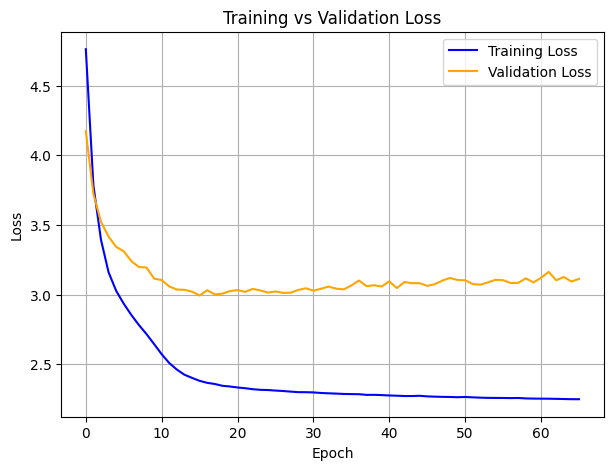

***************************
modelname:model_fold_1.ptを保存しました
*************************************Test*************************************
in constructor inchannel: 1
Input channel count10
model_dir =  model/20251008-ClaheStackedRecreation
Creating image arrays...
Number of label images: 12
Completed creating image arrays:
Dataset shape  (12, 256, 256, 1)
Label image shape  (12, 256, 256)

index =  0
予測画像: /home/eric/Documents/cervicalResearchIIP/result_test/20251008-ClaheStackedRecreation/fold1/N1-2.png
テストラベル: /home/eric/Documents/cervicalResearchIIP/img_1006t/labeled/N1-2.png
index =  1
予測画像: /home/eric/Documents/cervicalResearchIIP/result_test/20251008-ClaheStackedRecreation/fold1/N1-4.png
テストラベル: /home/eric/Documents/cervicalResearchIIP/img_1006t/labeled/N1-4.png
index =  2
予測画像: /home/eric/Documents/cervicalResearchIIP/result_test/20251008-ClaheStackedRecreation/fold1/N1-6.png
テストラベル: /home/eric/Documents/cervicalResearchIIP/img_1006t/labeled/N1-6.png
index =  3
予測画像: /home/eric

Progress:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 5.887220320557103
val_losses 5.721851709153917
lr 0.0001
Validation loss decreased (inf --> 5.721852).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 5.047350578597098
val_losses 5.1418771982193
lr 0.0001017999999999998
Validation loss decreased (5.721852 --> 5.141877).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 4.3290277733947296
val_losses 4.70403451124827
lr 0.00010360000000000001
Validation loss decreased (5.141877 --> 4.704035).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 3.887858231862386
val_losses 4.453743244542016
lr 0.00010539999999999981
Validation loss decreased (4.704035 --> 4.453743).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 3.6620076808062465
val_losses 4.398009358512031
lr 0.00010720000000000002
Validation loss decreased (4.453743 --> 4.398009).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 3.528222987868569
val_losses 4.375387250052558
lr 0.00010899999999999982
Validation loss decreased (4.398009 --> 4.375387).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 3.428555872223594
val_losses 4.334607524342007
lr 0.00011080000000000001
Validation loss decreased (4.375387 --> 4.334608).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 3.35466927615079
val_losses 4.3732572846942475
lr 0.00011259999999999981
EarlyStopping counter: 1 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 3.290479201259035
val_losses 4.364755331145393
lr 0.00011440000000000002
EarlyStopping counter: 2 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 3.218531673604792
val_losses 4.4684425036112465
lr 0.00011619999999999982
EarlyStopping counter: 3 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 3.1086942477659747
val_losses 4.468940336174435
lr 0.00011800000000000002
EarlyStopping counter: 4 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 2.9050034075072317
val_losses 4.245137594805824
lr 0.00011979999999999982
Validation loss decreased (4.334608 --> 4.245138).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 2.7670154253641766
val_losses 4.068468930986192
lr 0.00012160000000000003
Validation loss decreased (4.245138 --> 4.068469).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 2.5689499522700454
val_losses 4.12042684422599
lr 0.00012339999999999983
EarlyStopping counter: 1 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 2.50377676486969
val_losses 3.9941620177692836
lr 0.00012520000000000003
Validation loss decreased (4.068469 --> 3.994162).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 2.463956112572641
val_losses 4.100123936600156
lr 0.00012699999999999983
EarlyStopping counter: 1 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 2.4471168597539266
val_losses 4.019797970188988
lr 0.00012880000000000004
EarlyStopping counter: 2 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 2.4329631465854065
val_losses 4.1165419724252486
lr 0.00013059999999999984
EarlyStopping counter: 3 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 2.42219095880335
val_losses 4.2595782703823515
lr 0.00013240000000000002
EarlyStopping counter: 4 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 2.413075989665407
val_losses 4.119909626907773
lr 0.00013419999999999985
EarlyStopping counter: 5 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 2.408009492267262
val_losses 4.26216093301773
lr 0.00013600000000000003
EarlyStopping counter: 6 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 2.401069433038885
val_losses 4.195882009135352
lr 0.00013779999999999983
EarlyStopping counter: 7 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 2.396743728897788
val_losses 4.238798411687215
lr 0.00013960000000000003
EarlyStopping counter: 8 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 2.388225321336226
val_losses 4.200903791851467
lr 0.00014139999999999983
EarlyStopping counter: 9 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 2.3907424478819874
val_losses 4.501030969619751
lr 0.00014320000000000004
EarlyStopping counter: 10 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 2.402873171459545
val_losses 4.300622759924995
lr 0.00014499999999999984
EarlyStopping counter: 11 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 2.379862337401419
val_losses 4.312869555420345
lr 0.00014680000000000004
EarlyStopping counter: 12 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 2.373992934371486
val_losses 4.27783792813619
lr 0.00014859999999999984
EarlyStopping counter: 13 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 2.371032332651543
val_losses 4.234163893593682
lr 0.00015040000000000005
EarlyStopping counter: 14 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 2.3695515350861984
val_losses 4.468418455123901
lr 0.00015219999999999985
EarlyStopping counter: 15 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 2.369547815756364
val_losses 4.339226497544183
lr 0.00015400000000000006
EarlyStopping counter: 16 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 2.3679469151930377
val_losses 4.377024617460039
lr 0.00015579999999999986
EarlyStopping counter: 17 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 2.366244226513487
val_losses 4.391495845052931
lr 0.00015760000000000006
EarlyStopping counter: 18 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 2.5465445973656395
val_losses 3.932814411322276
lr 0.00015939999999999986
Validation loss decreased (3.994162 --> 3.932814).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 2.3975495034998113
val_losses 4.106282881895701
lr 0.00016120000000000007
EarlyStopping counter: 1 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 2.375969077601577
val_losses 4.034250293837653
lr 0.00016299999999999984
EarlyStopping counter: 2 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 2.3654612721818866
val_losses 4.104077166981167
lr 0.00016480000000000005
EarlyStopping counter: 3 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 2.3592880169550576
val_losses 4.1784238881535
lr 0.00016659999999999988
EarlyStopping counter: 4 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 2.3564296679063275
val_losses 4.230442145135668
lr 0.00016840000000000008
EarlyStopping counter: 5 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 2.35510279193069
val_losses 4.305743617481656
lr 0.00017019999999999985
EarlyStopping counter: 6 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 2.355531644821167
val_losses 4.374371572335561
lr 0.00017200000000000006
EarlyStopping counter: 7 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 2.35519211509011
val_losses 4.292827834023369
lr 0.0001737999999999999
EarlyStopping counter: 8 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 2.353489482764042
val_losses 4.358154116736518
lr 0.00017560000000000007
EarlyStopping counter: 9 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 2.3528802293719666
val_losses 4.309212921725379
lr 0.00017739999999999987
EarlyStopping counter: 10 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 2.3537109425573637
val_losses 4.281478419568804
lr 0.00017920000000000007
EarlyStopping counter: 11 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 2.3525210243282895
val_losses 4.414998743269178
lr 0.00018099999999999987
EarlyStopping counter: 12 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 2.3509012215065233
val_losses 4.441535985469818
lr 0.00018280000000000008
EarlyStopping counter: 13 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 2.3526048082293887
val_losses 4.418528978029887
lr 0.00018459999999999988
EarlyStopping counter: 14 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 2.3502456795085562
val_losses 4.416099694040087
lr 0.00018640000000000009
EarlyStopping counter: 15 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 2.3488583145719586
val_losses 4.3795536160469055
lr 0.00018819999999999989
EarlyStopping counter: 16 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 2.3474195140780822
val_losses 4.377174960242377
lr 0.00019000000000000006
EarlyStopping counter: 17 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 2.347378383260785
val_losses 4.520171191957262
lr 0.0001917999999999999
EarlyStopping counter: 18 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 2.345372666012157
val_losses 4.528056865268283
lr 0.0001936000000000001
EarlyStopping counter: 19 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 2.344316257130016
val_losses 4.412168451150259
lr 0.00019539999999999987
EarlyStopping counter: 20 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 2.347877509666212
val_losses 4.435553647412194
lr 0.00019720000000000008
EarlyStopping counter: 21 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 2.5338754812876383
val_losses 3.8988744642999436
lr 0.0001989999999999999
Validation loss decreased (3.932814 --> 3.898874).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 2.385755927634962
val_losses 4.0393457386228775
lr 0.0002008000000000001
EarlyStopping counter: 1 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 2.3651441675243956
val_losses 4.071218589941661
lr 0.00020259999999999988
EarlyStopping counter: 2 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 2.3532245592637495
val_losses 4.114323638545143
lr 0.0002044000000000001
EarlyStopping counter: 3 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 2.3462522412791396
val_losses 4.2064112080468075
lr 0.00020619999999999992
EarlyStopping counter: 4 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 2.3417052254532322
val_losses 4.285527198844486
lr 0.0002080000000000001
EarlyStopping counter: 5 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 2.3406511653553355
val_losses 4.324354342619578
lr 0.0002097999999999999
EarlyStopping counter: 6 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 2.340041143243963
val_losses 4.367757892608642
lr 0.0002116000000000001
EarlyStopping counter: 7 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 2.339522112499584
val_losses 4.31077670123842
lr 0.0002133999999999999
EarlyStopping counter: 8 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 2.3388832980936223
val_losses 4.412751939561632
lr 0.0002152000000000001
EarlyStopping counter: 9 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 2.3385864387859
val_losses 4.370533547136518
lr 0.0002169999999999999
EarlyStopping counter: 10 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 2.3395412878556683
val_losses 4.441652117835151
lr 0.00021880000000000011
EarlyStopping counter: 11 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 2.3384110335147743
val_losses 4.403478689988455
lr 0.00022059999999999991
EarlyStopping counter: 12 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 2.3381079290852402
val_losses 4.529554230637021
lr 0.0002224000000000001
EarlyStopping counter: 13 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 2.3372126160245954
val_losses 4.414922335412768
lr 0.00022419999999999992
EarlyStopping counter: 14 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 2.346918593753468
val_losses 4.563197918732961
lr 0.00022600000000000013
EarlyStopping counter: 15 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 2.468349343357664
val_losses 4.1334422058529325
lr 0.0002277999999999999
EarlyStopping counter: 16 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 2.3635646119262232
val_losses 4.328924710220761
lr 0.0002296000000000001
EarlyStopping counter: 17 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 2.346076409744494
val_losses 4.4180995994144014
lr 0.00023139999999999993
EarlyStopping counter: 18 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 2.3374837456327495
val_losses 4.46050822072559
lr 0.00023320000000000014
EarlyStopping counter: 19 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 2.3329069072549995
val_losses 4.518675402800242
lr 0.0002349999999999999
EarlyStopping counter: 20 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 2.3313362966884266
val_losses 4.588348527749379
lr 0.00023680000000000012
EarlyStopping counter: 21 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 2.3318949800549134
val_losses 4.478598450289832
lr 0.00023859999999999994
EarlyStopping counter: 22 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 2.332905615459789
val_losses 4.536089114348093
lr 0.00024040000000000015
EarlyStopping counter: 23 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 2.3313720565853697
val_losses 4.519556302494473
lr 0.00024219999999999992
EarlyStopping counter: 24 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 2.3317886460911144
val_losses 4.633916294574737
lr 0.00024400000000000013
EarlyStopping counter: 25 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 2.3322580843260794
val_losses 4.54400975174374
lr 0.00024579999999999996
EarlyStopping counter: 26 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 2.3315512158653955
val_losses 4.480062544345856
lr 0.0002476000000000001
EarlyStopping counter: 27 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 2.3297826225107365
val_losses 4.555486391650306
lr 0.00024939999999999994
EarlyStopping counter: 28 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 2.3297730893799753
val_losses 4.648750703864628
lr 0.00025120000000000014
EarlyStopping counter: 29 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 2.3296342394568703
val_losses 4.615706519285838
lr 0.0002529999999999999
EarlyStopping counter: 30 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 2.3301247278849284
val_losses 4.616634633806017
lr 0.0002548000000000001
EarlyStopping counter: 31 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 2.3294864849610764
val_losses 4.606978929042816
lr 0.00025659999999999995
EarlyStopping counter: 32 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 2.3291399124896888
val_losses 4.653161013126374
lr 0.00025840000000000016
EarlyStopping counter: 33 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 2.328692770726753
val_losses 4.693150571982065
lr 0.00026019999999999993
EarlyStopping counter: 34 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 2.3265271100130946
val_losses 4.646778772936927
lr 0.00026200000000000013
EarlyStopping counter: 35 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 2.325869570356427
val_losses 4.668404614925384
lr 0.00026379999999999996
EarlyStopping counter: 36 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 2.3258055528004964
val_losses 4.7160464750395885
lr 0.00026560000000000017
EarlyStopping counter: 37 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 2.325830276807149
val_losses 4.821778131855859
lr 0.00026739999999999994
EarlyStopping counter: 38 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 2.3251349803173182
val_losses 4.810827689700656
lr 0.00026920000000000015
EarlyStopping counter: 39 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 2.324024633927779
val_losses 4.689411067962647
lr 0.000271
EarlyStopping counter: 40 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 2.323499505447619
val_losses 4.842860168880886
lr 0.0002728000000000002
EarlyStopping counter: 41 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 2.3995203950188375
val_losses 4.148673005898794
lr 0.00027459999999999995
EarlyStopping counter: 42 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 2.3597450147975576
val_losses 4.435684953795539
lr 0.00027640000000000016
EarlyStopping counter: 43 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 2.332184648513794
val_losses 4.576838493347168
lr 0.00027819999999999993
EarlyStopping counter: 44 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 2.3220925136045976
val_losses 4.678516912460327
lr 0.00028000000000000014
EarlyStopping counter: 45 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 2.318907128680836
val_losses 4.780093710952335
lr 0.00028179999999999997
EarlyStopping counter: 46 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 2.3178310762752186
val_losses 4.760760858323839
lr 0.00028360000000000017
EarlyStopping counter: 47 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 2.3179777412703544
val_losses 4.821635172102186
lr 0.00028539999999999994
EarlyStopping counter: 48 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 2.318663626728636
val_losses 4.846555636988746
lr 0.00028720000000000015
EarlyStopping counter: 49 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 2.3194324963020554
val_losses 4.895613743199243
lr 0.000289
EarlyStopping counter: 50 out of 50
early stopping epoch: 105


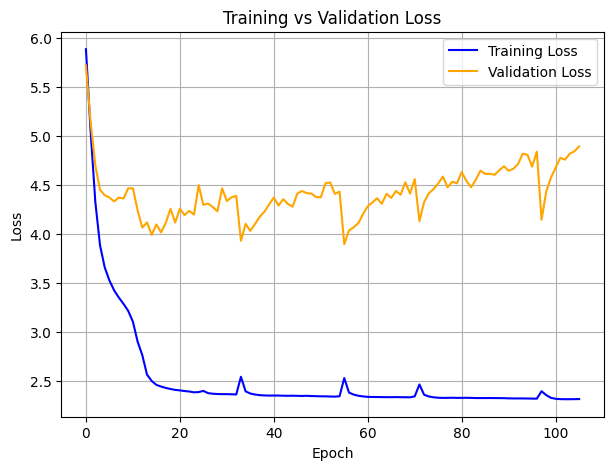

***************************
modelname:model_fold_2.ptを保存しました
*************************************Test*************************************
in constructor inchannel: 1
Input channel count10
model_dir =  model/20251008-ClaheStackedRecreation
Creating image arrays...
Number of label images: 11
Completed creating image arrays:
Dataset shape  (11, 256, 256, 1)
Label image shape  (11, 256, 256)

index =  0
予測画像: /home/eric/Documents/cervicalResearchIIP/result_test/20251008-ClaheStackedRecreation/fold2/N1-3.png
テストラベル: /home/eric/Documents/cervicalResearchIIP/img_1006t/labeled/N1-3.png
index =  1
予測画像: /home/eric/Documents/cervicalResearchIIP/result_test/20251008-ClaheStackedRecreation/fold2/N1-8.png
テストラベル: /home/eric/Documents/cervicalResearchIIP/img_1006t/labeled/N1-8.png
index =  2
予測画像: /home/eric/Documents/cervicalResearchIIP/result_test/20251008-ClaheStackedRecreation/fold2/N1-9.png
テストラベル: /home/eric/Documents/cervicalResearchIIP/img_1006t/labeled/N1-9.png
index =  3
予測画像: /home/eric

Progress:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 4.597461960532448
val_losses 4.214513285954793
lr 0.0001
Validation loss decreased (inf --> 4.214513).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 3.8304076888344505
val_losses 3.783794911702474
lr 0.0001017999999999998
Validation loss decreased (4.214513 --> 3.783795).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 3.468942369114269
val_losses 3.6107132196426392
lr 0.00010360000000000001
Validation loss decreased (3.783795 --> 3.610713).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 3.2937468015786373
val_losses 3.5316665093104045
lr 0.00010539999999999981
Validation loss decreased (3.610713 --> 3.531667).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 3.176600621685837
val_losses 3.49049353202184
lr 0.00010720000000000002
Validation loss decreased (3.531667 --> 3.490494).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 3.090361374797243
val_losses 3.43460207912657
lr 0.00010899999999999982
Validation loss decreased (3.490494 --> 3.434602).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 3.0189465775634305
val_losses 3.4274822235107423
lr 0.00011080000000000001
Validation loss decreased (3.434602 --> 3.427482).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 2.9525277918035333
val_losses 3.3728728691736856
lr 0.00011259999999999981
Validation loss decreased (3.427482 --> 3.372873).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 2.8730006275754985
val_losses 3.3464964442782934
lr 0.00011440000000000002
Validation loss decreased (3.372873 --> 3.346496).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 2.7780492479150944
val_losses 3.289411493142446
lr 0.00011619999999999982
Validation loss decreased (3.346496 --> 3.289411).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 2.6763226270675657
val_losses 3.239096783267127
lr 0.00011800000000000002
Validation loss decreased (3.289411 --> 3.239097).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 2.600894077618917
val_losses 3.2377894083658854
lr 0.00011979999999999982
Validation loss decreased (3.239097 --> 3.237789).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 2.54828571767518
val_losses 3.1981329454316034
lr 0.00012160000000000003
Validation loss decreased (3.237789 --> 3.198133).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 2.5179249582868635
val_losses 3.1721287661128574
lr 0.00012339999999999983
Validation loss decreased (3.198133 --> 3.172129).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 2.5028293725216026
val_losses 3.1759088860617743
lr 0.00012520000000000003
EarlyStopping counter: 1 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 2.48519126068462
val_losses 3.1762232369846766
lr 0.00012699999999999983
EarlyStopping counter: 2 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 2.4735575105204726
val_losses 3.136644379297892
lr 0.00012880000000000004
Validation loss decreased (3.172129 --> 3.136644).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 2.4639973373124096
val_losses 3.168139113320245
lr 0.00013059999999999984
EarlyStopping counter: 1 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 2.45833322207133
val_losses 3.1572502785258822
lr 0.00013240000000000002
EarlyStopping counter: 2 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 2.453359181953199
val_losses 3.169090563721127
lr 0.00013419999999999985
EarlyStopping counter: 3 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 2.4457260420828155
val_losses 3.175928450955285
lr 0.00013600000000000003
EarlyStopping counter: 4 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 2.44147897272399
val_losses 3.1451802995469835
lr 0.00013779999999999983
EarlyStopping counter: 5 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 2.437429436047872
val_losses 3.1886534916030036
lr 0.00013960000000000003
EarlyStopping counter: 6 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 2.4333024342854817
val_losses 3.1734922846158344
lr 0.00014139999999999983
EarlyStopping counter: 7 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 2.43718494718725
val_losses 3.203812175326877
lr 0.00014320000000000004
EarlyStopping counter: 8 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 2.428618378350229
val_losses 3.159631597995758
lr 0.00014499999999999984
EarlyStopping counter: 9 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 2.4238303032788364
val_losses 3.169721712006463
lr 0.00014680000000000004
EarlyStopping counter: 10 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 2.4203399181365968
val_losses 3.1791880249977114
lr 0.00014859999999999984
EarlyStopping counter: 11 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 2.4173511902491254
val_losses 3.1690364758173626
lr 0.00015040000000000005
EarlyStopping counter: 12 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 2.4158487421093566
val_losses 3.215397486421797
lr 0.00015219999999999985
EarlyStopping counter: 13 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 2.4130595525105796
val_losses 3.184583180480533
lr 0.00015400000000000006
EarlyStopping counter: 14 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 2.4119728897557113
val_losses 3.1937312483787537
lr 0.00015579999999999986
EarlyStopping counter: 15 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 2.4084598635182237
val_losses 3.1828078402413262
lr 0.00015760000000000006
EarlyStopping counter: 16 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 2.4076772516424008
val_losses 3.1901626427968344
lr 0.00015939999999999986
EarlyStopping counter: 17 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 2.4050324895165183
val_losses 3.1947688513331944
lr 0.00016120000000000007
EarlyStopping counter: 18 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 2.403039735736269
val_losses 3.200387896431817
lr 0.00016299999999999984
EarlyStopping counter: 19 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 2.401930643572952
val_losses 3.1970868892139856
lr 0.00016480000000000005
EarlyStopping counter: 20 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 2.3995205395149464
val_losses 3.1802158700095284
lr 0.00016659999999999988
EarlyStopping counter: 21 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 2.398424193353364
val_losses 3.184307531515757
lr 0.00016840000000000008
EarlyStopping counter: 22 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 2.395012765942198
val_losses 3.174344213803609
lr 0.00017019999999999985
EarlyStopping counter: 23 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 2.3936347766356034
val_losses 3.21203660302692
lr 0.00017200000000000006
EarlyStopping counter: 24 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 2.393562654292945
val_losses 3.2194810734854804
lr 0.0001737999999999999
EarlyStopping counter: 25 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 2.3939631245353006
val_losses 3.189117064740923
lr 0.00017560000000000007
EarlyStopping counter: 26 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 2.3902617266683865
val_losses 3.197107348177168
lr 0.00017739999999999987
EarlyStopping counter: 27 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 2.388069108760718
val_losses 3.2020929879612394
lr 0.00017920000000000007
EarlyStopping counter: 28 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 2.385720296339555
val_losses 3.221298733022478
lr 0.00018099999999999987
EarlyStopping counter: 29 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 2.3844534960660067
val_losses 3.2149200386471217
lr 0.00018280000000000008
EarlyStopping counter: 30 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 2.3843361298243204
val_losses 3.208051449722714
lr 0.00018459999999999988
EarlyStopping counter: 31 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 2.3826769857695607
val_losses 3.2314788010385302
lr 0.00018640000000000009
EarlyStopping counter: 32 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 2.3875536514051032
val_losses 3.197580729590522
lr 0.00018819999999999989
EarlyStopping counter: 33 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 2.382990191199563
val_losses 3.256441311041514
lr 0.00019000000000000006
EarlyStopping counter: 34 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 2.378733811233983
val_losses 3.2527576790915593
lr 0.0001917999999999999
EarlyStopping counter: 35 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 2.3783485925558843
val_losses 3.1987828652064008
lr 0.0001936000000000001
EarlyStopping counter: 36 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 2.3777338353070347
val_losses 3.2151024381319684
lr 0.00019539999999999987
EarlyStopping counter: 37 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 2.3755182923692644
val_losses 3.22086916897032
lr 0.00019720000000000008
EarlyStopping counter: 38 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 2.3758958318016745
val_losses 3.2195294380187987
lr 0.0001989999999999999
EarlyStopping counter: 39 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 2.376214225364454
val_losses 3.253317595852746
lr 0.0002008000000000001
EarlyStopping counter: 40 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 2.375813782576359
val_losses 3.2364909132321675
lr 0.00020259999999999988
EarlyStopping counter: 41 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 2.3743359652432527
val_losses 3.229996637503306
lr 0.0002044000000000001
EarlyStopping counter: 42 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 2.373736364191229
val_losses 3.2389714161554974
lr 0.00020619999999999992
EarlyStopping counter: 43 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 2.3711906021291558
val_losses 3.226361824406518
lr 0.0002080000000000001
EarlyStopping counter: 44 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 2.3698490699132284
val_losses 3.2723474237653942
lr 0.0002097999999999999
EarlyStopping counter: 45 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 2.3698506781549167
val_losses 3.249604896704356
lr 0.0002116000000000001
EarlyStopping counter: 46 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 2.37260816747492
val_losses 3.2438905649715
lr 0.0002133999999999999
EarlyStopping counter: 47 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 2.369206509445653
val_losses 3.251885692278544
lr 0.0002152000000000001
EarlyStopping counter: 48 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 2.366442345127915
val_losses 3.235786853896247
lr 0.0002169999999999999
EarlyStopping counter: 49 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 2.366772835904902
val_losses 3.2408476948738096
lr 0.00021880000000000011
EarlyStopping counter: 50 out of 50
early stopping epoch: 66


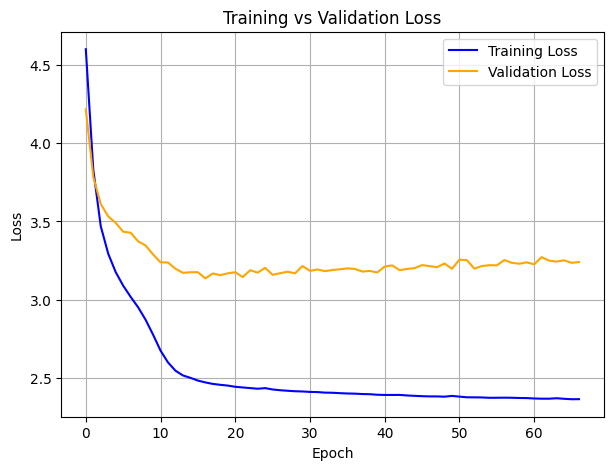

***************************
modelname:model_fold_3.ptを保存しました
*************************************Test*************************************
in constructor inchannel: 1
Input channel count10
model_dir =  model/20251008-ClaheStackedRecreation
Creating image arrays...
Number of label images: 11
Completed creating image arrays:
Dataset shape  (11, 256, 256, 1)
Label image shape  (11, 256, 256)

index =  0
予測画像: /home/eric/Documents/cervicalResearchIIP/result_test/20251008-ClaheStackedRecreation/fold3/N1-5.png
テストラベル: /home/eric/Documents/cervicalResearchIIP/img_1006t/labeled/N1-5.png
index =  1
予測画像: /home/eric/Documents/cervicalResearchIIP/result_test/20251008-ClaheStackedRecreation/fold3/N1-10.png
テストラベル: /home/eric/Documents/cervicalResearchIIP/img_1006t/labeled/N1-10.png
index =  2
予測画像: /home/eric/Documents/cervicalResearchIIP/result_test/20251008-ClaheStackedRecreation/fold3/N2-4.png
テストラベル: /home/eric/Documents/cervicalResearchIIP/img_1006t/labeled/N2-4.png
index =  3
予測画像: /home/er

Progress:   0%|          | 0/200 [00:00<?, ?it/s]

Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 14.494841939752751
val_losses 10.963910452524821
lr 0.0001
Validation loss decreased (inf --> 10.963910).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 8.259843821959063
val_losses 7.720359921455383
lr 0.0001017999999999998
Validation loss decreased (10.963910 --> 7.720360).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 5.6332284248236455
val_losses 6.271344595485264
lr 0.00010360000000000001
Validation loss decreased (7.720360 --> 6.271345).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 4.3334228226632785
val_losses 5.764944079187181
lr 0.00010539999999999981
Validation loss decreased (6.271345 --> 5.764944).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 3.5591734142014473
val_losses 5.182282830609216
lr 0.00010720000000000002
Validation loss decreased (5.764944 --> 5.182283).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 3.0439545660307914
val_losses 4.9330364081594675
lr 0.00010899999999999982
Validation loss decreased (5.182283 --> 4.933036).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 2.650679203235742
val_losses 4.747709461053213
lr 0.00011080000000000001
Validation loss decreased (4.933036 --> 4.747709).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 2.3225774096720144
val_losses 4.687293452686734
lr 0.00011259999999999981
Validation loss decreased (4.747709 --> 4.687293).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 1.9355781100013039
val_losses 4.432124932607015
lr 0.00011440000000000002
Validation loss decreased (4.687293 --> 4.432125).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 1.5524147329908429
val_losses 4.458580635653602
lr 0.00011619999999999982
EarlyStopping counter: 1 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 1.234661833083991
val_losses 4.078542440467411
lr 0.00011800000000000002
Validation loss decreased (4.432125 --> 4.078542).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.9235689983223424
val_losses 3.7703414777914683
lr 0.00011979999999999982
Validation loss decreased (4.078542 --> 3.770341).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.8662609792116917
val_losses 3.606405242946413
lr 0.00012160000000000003
Validation loss decreased (3.770341 --> 3.606405).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.512434819431016
val_losses 3.4952370153533088
lr 0.00012339999999999983
Validation loss decreased (3.606405 --> 3.495237).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.4013797788908987
val_losses 3.495728384123908
lr 0.00012520000000000003
EarlyStopping counter: 1 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.332275049794804
val_losses 3.5779242257277173
lr 0.00012699999999999983
EarlyStopping counter: 2 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.33207156694296636
val_losses 3.486778087086148
lr 0.00012880000000000004
Validation loss decreased (3.495237 --> 3.486778).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.2571899663318287
val_losses 3.3765199648009405
lr 0.00013059999999999984
Validation loss decreased (3.486778 --> 3.376520).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.22258458986426843
val_losses 3.606218667825063
lr 0.00013240000000000002
EarlyStopping counter: 1 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.2373753628947518
val_losses 3.5728703412744736
lr 0.00013419999999999985
EarlyStopping counter: 2 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.23486948880282316
val_losses 3.4045685900582208
lr 0.00013600000000000003
EarlyStopping counter: 3 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.1783337939869274
val_losses 3.5580906762017146
lr 0.00013779999999999983
EarlyStopping counter: 4 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.17502566467631947
val_losses 3.382588826285468
lr 0.00013960000000000003
EarlyStopping counter: 5 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.1535243590672811
val_losses 3.513976964685652
lr 0.00014139999999999983
EarlyStopping counter: 6 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.1379126129728375
val_losses 3.726610658566157
lr 0.00014320000000000004
EarlyStopping counter: 7 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.12515000502268472
val_losses 3.7446125699414146
lr 0.00014499999999999984
EarlyStopping counter: 8 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.12242372505592578
val_losses 3.729195656379064
lr 0.00014680000000000004
EarlyStopping counter: 9 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.11152135386611477
val_losses 3.700360090865029
lr 0.00014859999999999984
EarlyStopping counter: 10 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.48117576711105575
val_losses 2.608570083644655
lr 0.00015040000000000005
Validation loss decreased (3.376520 --> 2.608570).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.5079988230358471
val_losses 2.4674319518937007
lr 0.00015219999999999985
Validation loss decreased (2.608570 --> 2.467432).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.21516814051252423
val_losses 2.715589035219616
lr 0.00015400000000000006
EarlyStopping counter: 1 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.15571415424346924
val_losses 2.990519561370214
lr 0.00015579999999999986
EarlyStopping counter: 2 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.12378455436590946
val_losses 3.093906886047787
lr 0.00015760000000000006
EarlyStopping counter: 3 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.10373542381055427
val_losses 3.2567767249213326
lr 0.00015939999999999986
EarlyStopping counter: 4 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.08952607891776344
val_losses 3.299741067488988
lr 0.00016120000000000007
EarlyStopping counter: 5 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.08167191274238356
val_losses 3.4707603573799135
lr 0.00016299999999999984
EarlyStopping counter: 6 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.07895271922602798
val_losses 3.429012702571021
lr 0.00016480000000000005
EarlyStopping counter: 7 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.07682325117515795
val_losses 3.527050618330638
lr 0.00016659999999999988
EarlyStopping counter: 8 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0722804434371717
val_losses 3.5834911697440677
lr 0.00016840000000000008
EarlyStopping counter: 9 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.06817611997777766
val_losses 3.4518438822693294
lr 0.00017019999999999985
EarlyStopping counter: 10 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0886542544220433
val_losses 3.4797927578290304
lr 0.00017200000000000006
EarlyStopping counter: 11 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.06756726214379975
val_losses 3.482015813059277
lr 0.0001737999999999999
EarlyStopping counter: 12 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.05614258231538715
val_losses 3.490052394072215
lr 0.00017560000000000007
EarlyStopping counter: 13 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.05442476091962872
val_losses 3.3523441990216574
lr 0.00017739999999999987
EarlyStopping counter: 14 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.051750123500823975
val_losses 3.5331422170003255
lr 0.00017920000000000007
EarlyStopping counter: 15 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.1024566756956505
val_losses 3.520013015137778
lr 0.00018099999999999987
EarlyStopping counter: 16 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.7452945602662635
val_losses 2.0533448775609333
lr 0.00018280000000000008
Validation loss decreased (2.467432 --> 2.053345).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.21419300996895993
val_losses 2.3424829973114862
lr 0.00018459999999999988
EarlyStopping counter: 1 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.14581288063164913
val_losses 2.5129017770290374
lr 0.00018640000000000009
EarlyStopping counter: 2 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.1094532771544023
val_losses 2.7124259816275704
lr 0.00018819999999999989
EarlyStopping counter: 3 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.08604402686610366
val_losses 2.8899425950315263
lr 0.00019000000000000006
EarlyStopping counter: 4 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.06932578086853028
val_losses 2.933942323923111
lr 0.0001917999999999999
EarlyStopping counter: 5 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.05925961010383837
val_losses 3.0801492042011684
lr 0.0001936000000000001
EarlyStopping counter: 6 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.051945276693864305
val_losses 3.134434630473455
lr 0.00019539999999999987
EarlyStopping counter: 7 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.045145956313971315
val_losses 3.1878066506650713
lr 0.00019720000000000008
EarlyStopping counter: 8 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.04358521302541097
val_losses 3.2468180603451198
lr 0.0001989999999999999
EarlyStopping counter: 9 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.04051521980401242
val_losses 3.1782247953944736
lr 0.0002008000000000001
EarlyStopping counter: 10 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.036851018125360666
val_losses 3.273106007443534
lr 0.00020259999999999988
EarlyStopping counter: 11 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.03652271068457401
val_losses 3.199846937921312
lr 0.0002044000000000001
EarlyStopping counter: 12 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.036317231077136414
val_losses 3.2515570415390864
lr 0.00020619999999999992
EarlyStopping counter: 13 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.03181278524976788
val_losses 3.1986293845706517
lr 0.0002080000000000001
EarlyStopping counter: 14 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.024798761353348242
val_losses 3.422082010904948
lr 0.0002097999999999999
EarlyStopping counter: 15 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.024965332493637547
val_losses 3.3579563836256665
lr 0.0002116000000000001
EarlyStopping counter: 16 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.020604564926841044
val_losses 3.3934516178237066
lr 0.0002133999999999999
EarlyStopping counter: 17 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.01889132730888598
val_losses 3.436685995923148
lr 0.0002152000000000001
EarlyStopping counter: 18 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.01675089525453972
val_losses 3.4966072499752046
lr 0.0002169999999999999
EarlyStopping counter: 19 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.013715232141090161
val_losses 3.3864463826020557
lr 0.00021880000000000011
EarlyStopping counter: 20 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.006033845381303267
val_losses 3.4229343401061163
lr 0.00022059999999999991
EarlyStopping counter: 21 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.004610215172623143
val_losses 3.493218186166551
lr 0.0002224000000000001
EarlyStopping counter: 22 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.007595930316231467
val_losses 3.567929975854026
lr 0.00022419999999999992
EarlyStopping counter: 23 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0012670285773999763
val_losses 3.74476962685585
lr 0.00022600000000000013
EarlyStopping counter: 24 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses -0.005923918883005778
val_losses 3.6213337063789366
lr 0.0002277999999999999
EarlyStopping counter: 25 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.00108478358297637
val_losses 3.391703638103273
lr 0.0002296000000000001
EarlyStopping counter: 26 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses -0.00538604837475401
val_losses 3.7515272160371143
lr 0.00023139999999999993
EarlyStopping counter: 27 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses -0.010148516568270597
val_losses 3.5872304492526585
lr 0.00023320000000000014
EarlyStopping counter: 28 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses -0.011285690466562907
val_losses 3.72777021990882
lr 0.0002349999999999999
EarlyStopping counter: 29 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses -0.014157836003737016
val_losses 3.604712478319804
lr 0.00023680000000000012
EarlyStopping counter: 30 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses -0.016715388225786613
val_losses 3.7049593971835244
lr 0.00023859999999999994
EarlyStopping counter: 31 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses -0.011731895172234738
val_losses 3.7485410961839887
lr 0.00024040000000000015
EarlyStopping counter: 32 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses -0.021381172628113718
val_losses 3.773449225558175
lr 0.00024219999999999992
EarlyStopping counter: 33 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses -0.026391561103589607
val_losses 3.964545761876636
lr 0.00024400000000000013
EarlyStopping counter: 34 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses -0.0230075377406496
val_losses 4.047854880491893
lr 0.00024579999999999996
EarlyStopping counter: 35 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses -0.02764640504663641
val_losses 3.8891424311531915
lr 0.0002476000000000001
EarlyStopping counter: 36 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses -0.030811084400523794
val_losses 3.813607198662228
lr 0.00024939999999999994
EarlyStopping counter: 37 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.36956967404394436
val_losses 1.8435393316878212
lr 0.00025120000000000014
Validation loss decreased (2.053345 --> 1.843539).  Saving model ...


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.19072051626263242
val_losses 2.2517483078771168
lr 0.0002529999999999999
EarlyStopping counter: 1 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.07851072874936191
val_losses 2.595412677526474
lr 0.0002548000000000001
EarlyStopping counter: 2 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.030684135899399265
val_losses 2.919125219848421
lr 0.00025659999999999995
EarlyStopping counter: 3 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.0005110502243041992
val_losses 3.088953581121233
lr 0.00025840000000000016
EarlyStopping counter: 4 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses -0.02001386628006444
val_losses 3.328121076027552
lr 0.00026019999999999993
EarlyStopping counter: 5 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses -0.03081676887743401
val_losses 3.514462182919184
lr 0.00026200000000000013
EarlyStopping counter: 6 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses -0.03413486552960945
val_losses 3.610520617167155
lr 0.00026379999999999996
EarlyStopping counter: 7 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses -0.03656192656719323
val_losses 3.6197705957624646
lr 0.00026560000000000017
EarlyStopping counter: 8 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses -0.03724427728941946
val_losses 3.6666375352276694
lr 0.00026739999999999994
EarlyStopping counter: 9 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses -0.03412809046831998
val_losses 3.704537531402376
lr 0.00026920000000000015
EarlyStopping counter: 10 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses -0.03552217266776345
val_losses 3.8096692469384936
lr 0.000271
EarlyStopping counter: 11 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses -0.03633603905186509
val_losses 3.7055383410718705
lr 0.0002728000000000002
EarlyStopping counter: 12 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses -0.039759363188888085
val_losses 3.850268530845642
lr 0.00027459999999999995
EarlyStopping counter: 13 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses -0.04040147752472849
val_losses 3.9930139117770724
lr 0.00027640000000000016
EarlyStopping counter: 14 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses -0.03712039896936128
val_losses 3.9516790482732986
lr 0.00027819999999999993
EarlyStopping counter: 15 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses -0.039711061029723195
val_losses 3.7892276578479342
lr 0.00028000000000000014
EarlyStopping counter: 16 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses -0.042143746217091875
val_losses 3.787830540868971
lr 0.00028179999999999997
EarlyStopping counter: 17 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses -0.043262082157712996
val_losses 4.021528971195221
lr 0.00028360000000000017
EarlyStopping counter: 18 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses -0.04505260135188247
val_losses 3.9532067007488676
lr 0.00028539999999999994
EarlyStopping counter: 19 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses -0.04672653819575454
val_losses 3.879194254345364
lr 0.00028720000000000015
EarlyStopping counter: 20 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses -0.047369674480322636
val_losses 3.8438494364420572
lr 0.000289
EarlyStopping counter: 21 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses -0.04860371784730391
val_losses 4.126749506261613
lr 0.0002908000000000002
EarlyStopping counter: 22 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses -0.0466984358700839
val_losses 3.9206641687287225
lr 0.00029259999999999996
EarlyStopping counter: 23 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses -0.052082395553588866
val_losses 3.951375014252133
lr 0.00029440000000000016
EarlyStopping counter: 24 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses -0.05276564612533107
val_losses 3.9632909920480515
lr 0.0002962
EarlyStopping counter: 25 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses -0.05248772447759455
val_losses 3.9008478509055244
lr 0.0002980000000000002
EarlyStopping counter: 26 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses -0.05199556784196333
val_losses 3.860844502184126
lr 0.00029979999999999997
EarlyStopping counter: 27 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses -0.05783612944863059
val_losses 4.0538483752144705
lr 0.0003016000000000002
EarlyStopping counter: 28 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses -0.05697986248767737
val_losses 4.154709038469527
lr 0.0003034
EarlyStopping counter: 29 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses -0.0573342836264408
val_losses 4.098667025566101
lr 0.00030520000000000015
EarlyStopping counter: 30 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses -0.05908569892247518
val_losses 4.151831512980991
lr 0.000307
EarlyStopping counter: 31 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses -0.0594453544327707
val_losses 4.088659448093838
lr 0.0003088000000000002
EarlyStopping counter: 32 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses -0.059039855003356935
val_losses 4.112286673651801
lr 0.00031059999999999996
EarlyStopping counter: 33 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses -0.06192406849427657
val_losses 4.119227740499708
lr 0.0003123999999999998
EarlyStopping counter: 34 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses -0.06238847934838497
val_losses 4.199331609408061
lr 0.0003142
EarlyStopping counter: 35 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses -0.06661438761335431
val_losses 4.337977564334869
lr 0.0003160000000000002
EarlyStopping counter: 36 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses -0.065773437239907
val_losses 4.37116336690055
lr 0.00031779999999999997
EarlyStopping counter: 37 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses -0.06600123716123177
val_losses 4.268321057160695
lr 0.0003195999999999998
EarlyStopping counter: 38 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses -0.06636372009913126
val_losses 4.336097447077433
lr 0.0003214
EarlyStopping counter: 39 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses -0.06635371988469904
val_losses 4.41729828119278
lr 0.0003232000000000002
EarlyStopping counter: 40 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses -0.06891666650772095
val_losses 4.326283258861966
lr 0.000325
EarlyStopping counter: 41 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses -0.06960068399255925
val_losses 4.321600461006165
lr 0.0003267999999999998
EarlyStopping counter: 42 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses -0.0695684602766326
val_losses 4.410864901542664
lr 0.0003286
EarlyStopping counter: 43 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses -0.07164756493134931
val_losses 4.527884194586012
lr 0.0003304000000000002
EarlyStopping counter: 44 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses -0.07044018579251839
val_losses 4.351224822468228
lr 0.0003322
EarlyStopping counter: 45 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses -0.07337399179285223
val_losses 4.492886389626397
lr 0.0003339999999999998
EarlyStopping counter: 46 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses -0.07437907926964038
val_losses 4.462858888838026
lr 0.00033580000000000003
EarlyStopping counter: 47 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.3504506501284513
val_losses 2.0924897965457703
lr 0.0003376000000000002
EarlyStopping counter: 48 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.09447265899542606
val_losses 2.515341223610772
lr 0.0003394
EarlyStopping counter: 49 out of 50


Training:   0%|          | 0/330 [00:00<?, ?it/s]

Validation:   0%|          | 0/180 [00:00<?, ?it/s]

train_losses 0.012184934543840812
val_losses 2.9842421730359394
lr 0.00034119999999999984
EarlyStopping counter: 50 out of 50
early stopping epoch: 134


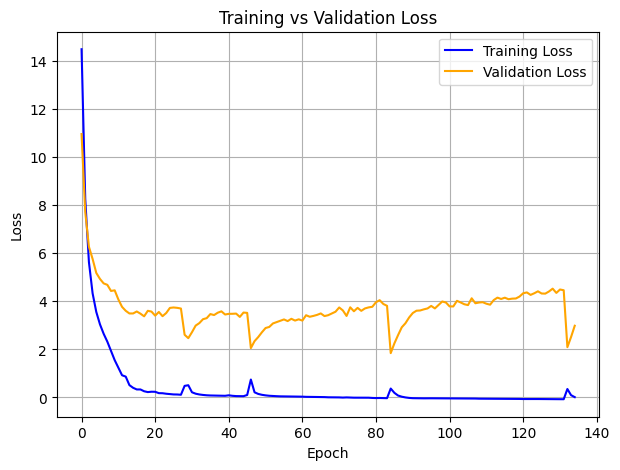

***************************
modelname:model_fold_4.ptを保存しました
*************************************Test*************************************
in constructor inchannel: 1
Input channel count10
model_dir =  model/20251008-ClaheStackedRecreation
Creating image arrays...
Number of label images: 11
Completed creating image arrays:
Dataset shape  (11, 256, 256, 1)
Label image shape  (11, 256, 256)

index =  0
予測画像: /home/eric/Documents/cervicalResearchIIP/result_test/20251008-ClaheStackedRecreation/fold4/N1-1.png
テストラベル: /home/eric/Documents/cervicalResearchIIP/img_1006t/labeled/N1-1.png
index =  1
予測画像: /home/eric/Documents/cervicalResearchIIP/result_test/20251008-ClaheStackedRecreation/fold4/N1-7.png
テストラベル: /home/eric/Documents/cervicalResearchIIP/img_1006t/labeled/N1-7.png
index =  2
予測画像: /home/eric/Documents/cervicalResearchIIP/result_test/20251008-ClaheStackedRecreation/fold4/N2-3.png
テストラベル: /home/eric/Documents/cervicalResearchIIP/img_1006t/labeled/N2-3.png
index =  3
予測画像: /home/eric

In [ ]:
## Execution
from dataArrange import dataRearrange1
## Test Learn_EA without annealing
# training transformations and augmentations

transforms_training = ComposeDouble([
    FunctionWrapperDouble(create_dense_target, input=False, target=True),
    FunctionWrapperDouble(np.moveaxis, input=True, target=False, source=-1, destination=0),
    FunctionWrapperDouble(normalize_01)
])

#追加箇所ver3
transforms_val =  ComposeDouble([
    FunctionWrapperDouble(create_dense_target, input=False, target=True),
    FunctionWrapperDouble(np.moveaxis, input=True, target=False, source=-1, destination=0),
    FunctionWrapperDouble(normalize_01)

])

# random seed
random_seed = 0

X = file_names_with_prefix(data_dir, 'N')

y_file_names = file_names_with_prefix(labeled_dir, 'N')


y = [label_group[:2] for label_group in y_file_names]

X = np.array(X)
y = np.array(y)

print(X)
print(y)


if CROSS_VAL:
    skf = StratifiedKFold(n_splits=N_SPLIT, shuffle=True)
    # each case same division
    #skf = StratifiedKFold(n_splits=N_SPLIT, shuffle=True, random_state=42)
    for fold, (train_index, test_index) in enumerate(skf.split(X, y), 1):
        # if fold != 4:
        #      continue
        # Split the data into train and test sets
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        # Split the training data further into train and validation ( 1/3 split)
        X_train_final, X_val, y_train_final, y_val = train_test_split(
            X_train, y_train, test_size=0.333333333, random_state=42, stratify=y_train)
        
        
        input_train = X_train_final
        input_name_val = X_val
        print("Cross validation: " + str(CROSS_VAL))
        print(f"Fold: {fold} out of {N_SPLIT}")
        print("Augmentation: " + str(AUGMENTED))
        if AUGMENTED:
            print("Augmentation amount: " + str(AUGMENTATION))
        print("Training: Total of " + str(len(input_train)) + " cases.")
        print(input_train)

        print("Validation: Total of " + str(len(input_name_val)) + " cases.")
        print(input_name_val)
        
        print("Test: Total of " + str(len(X_test)) + " cases.")  
        print(X_test)
        print()
        
        if AUGMENTED:
            ## This part is for accounting the data augmentation, attaches augmentation numbers after the original img
            ## ex: original number N1-1 -> N1-1-1, N1-1-2 etc.
            repeated_items_train = np.repeat(input_train, AUGMENTATION)
            suffixes_train = np.tile(np.arange(1, AUGMENTATION + 1), len(repeated_items_train))
            input_train = np.array([f"{item}-{suffix}" for item, suffix in zip(repeated_items_train, suffixes_train)])
            #Custom Arranging for training dataset because of the augmentation order
            input_train = np.array(dataRearrange1(input_train, AUGMENTATION))
            
            
            repeated_items_val = np.repeat(input_name_val, AUGMENTATION)
            suffixes_val = np.tile(np.arange(1, AUGMENTATION + 1), len(repeated_items_val))
            input_name_val = np.array([f"{item}-{suffix}" for item, suffix in zip(repeated_items_val, suffixes_val)])
        
        
        #input_dataset,label_dataset = CreateWeightImageNew(input_train, augmentation=AUGMENTED)
        input_dataset,label_dataset = CreateWeightImage(input_train, augmentation=AUGMENTED)
        input_dataset_val,label_dataset_val = CreateWeightImage(input_name_val, augmentation=AUGMENTED)
         
        
        Learn_EA(input_dataset,label_dataset,input_dataset_val,label_dataset_val, 0, fold)
        mConv_predict(X_test, fold)
        
        # Force garbage collection
        gc.collect()

        # Clear CUDA memory
        torch.cuda.empty_cache()

        # Optionally reset max memory tracking
        torch.cuda.reset_peak_memory_stats()
        
else:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=RANDOM_SEED)
    
    X_train_final, X_val, y_train_final, y_val = train_test_split(
            X_train, y_train, test_size=0.333333333, random_state=42, stratify=y_train)
    
    input_train = X_train_final
    input_name_val = X_val
    
    print("Cross validation: " + str(CROSS_VAL))
    print("Augmentation: " + str(AUGMENTED))
    if AUGMENTED:
        print("Augmentation amount: " + str(AUGMENTATION))
    print("Training: Total of " + str(len(input_train)) + " cases.")
    print(input_train)

    print("Validation: Total of " + str(len(input_name_val)) + " cases.")
    print(input_name_val)
        
    print("Test: Total of " + str(len(X_test)) + " cases.")  
    print(X_test)
    print()
    
    if AUGMENTED:
        ## This part is for accounting the data augmentation, attaches augmentation numbers after the original img
        ## ex: original number N1-1 -> N1-1-1, N1-1-2 etc.
        repeated_items_train = np.repeat(input_train, AUGMENTATION)
        suffixes_train = np.tile(np.arange(1, AUGMENTATION + 1), len(repeated_items_train))
        input_train = np.array([f"{item}-{suffix}" for item, suffix in zip(repeated_items_train, suffixes_train)])
        
        #Custom Arranging for training dataset because of the augmentation order
        input_train = np.array(dataRearrange1(input_train, AUGMENTATION))
            
            
        repeated_items_val = np.repeat(input_name_val, AUGMENTATION)
        suffixes_val = np.tile(np.arange(1, AUGMENTATION + 1), len(repeated_items_val))
        input_name_val = np.array([f"{item}-{suffix}" for item, suffix in zip(repeated_items_val, suffixes_val)])
    
    input_dataset,label_dataset = CreateWeightImage(input_train, augmentation=AUGMENTED)
    input_dataset_val,label_dataset_val = CreateWeightImage(input_name_val, augmentation=AUGMENTED)
    
    
    
    # # ### lastly added for weig
    # ht management
    # weights = weights.view(1, 1, 1, -1)  # Reshape for broadcasting
    
    # #making pytorch tensor
    # input_dataset = torch.tensor(input_dataset, dtype=torch.float32)
    # input_dataset_val = torch.tensor(input_dataset_val, dtype=torch.float32)
    # weights = torch.tensor(weights, dtype=torch.float32)
    
    # input_dataset = input_dataset * weights
    # input_dataset_val = input_dataset_val * weights
    # input_dataset = input_dataset.numpy()
    # input_dataset_val = input_dataset_val.numpy()
    Learn_EA(input_dataset,label_dataset,input_dataset_val,label_dataset_val, 0)
    mConv_predict(X_test)
    
    # Force garbage collection
    gc.collect()

    # Clear CUDA memory
    torch.cuda.empty_cache()

    # Optionally reset max memory tracking
    torch.cuda.reset_peak_memory_stats()
    
    

In [21]:
# df_optuna = pd.DataFrame(columns = ['Dice_importance', 'CE_importance', "Dice"])
# def objective(trial):
#     N_BLOCK = 5
#     LR = 0.003
                                                                                                        
#     OUTPUT_DIR = '20250528-DiCELossOptimization'
    
#     print(f"Trial {trial.number}")

#     IN_CHANNEL = 108

#     AUGMENTED = False
#     AUGMENTATION  =  30


#     CROSS_VAL = False
#     N_SPLIT = 4
    
#     DICE_IMPORTANCE = trial.suggest_float("dice_importance", 1.0, 100.0)
#     CE_IMPORTANCE = trial.suggest_float("ce_importance", 1.0, 100.0)
       
    
#     dice_val = executeExperiment()
    
#     #df_optuna.add([DICE_IMPORTANCE, CE_IMPORTANCE, dice_val])
#     return dice_val
    
# import optuna

# # Create a study to minimize or maximize the metric
# study = optuna.create_study(direction='maximize')  # or 'minimize' based on your metric
# study.optimize(objective, n_trials = 360)
# #df_optuna.to_csv("optuna_optimization_loss_function.csv") 
    
    


In [22]:

# print(study.best_params)
# study.best_value